# Analytics On Spotify Dataset :- 
### Project Topic :- Using spotify songs, to get regional sentiments and see how it correlates with the financial stock market data

### The following block of code is necessary to load all essential packages, that would eventually be used in this notebook

In [1]:
!pip install wordcloud
!pip install pandas_datareader
!pip install pmdarima

In [2]:
#loading necessary librarires
#Pandas for importing csv and performing manipulation of dataframe
import pandas as pd
#Numpy for matrix manipulation
import numpy as np
#Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
#Spotipy for accessing spotify music database
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
#Regular expression
import re
# importing tqdm to get loading bar
from tqdm import tqdm
#Importing statmodel package to check the stationarity 
from statsmodels.tsa.stattools import adfuller
#importing the statmodel package to make ACF and PACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Suppressing,the warning  
import warnings
warnings.filterwarnings('ignore')
#Importing package to perform forecasting
from statsmodels.tsa.arima_model import ARIMA
#import statsmodels.tsa.arima.model.ARIMA
from statsmodels.tsa.arima.model import ARIMA
#importing package to implement auto_arima
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.innovations import arma_innovations
#package for box-cox transformation
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
#package to perform multiple linear regression and to get its mtrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#package to get wordcloud
from wordcloud import WordCloud
#plt.style.use("fivethirtyeight")
#loading necessary libraries
from pandas_datareader.data import DataReader
#loading datetime library to call the relavant stock market data
from datetime import datetime
import statsmodels.api as sm
sns.set_style("whitegrid")


### Spotify releases daily, as well as weekly top 200 songs data on "spotifycharts.com", with details of title, rank, date, artist name, region and no of streams

### For our purpose, we have collected daily top 200 songs starting from 2017-01-01 till 2021-07-31, this was collected from kaggle, the link to the dataset is :-
### https://www.kaggle.com/datasets/dhruvildave/spotify-charts


In [3]:
#Importing the dataset 
Reading_csv = pd.read_csv("D:\charts.csv\charts.csv")

### Exploratory Data Analysis  

### Lets see the first five rows of the dataset to understand the data better

In [4]:
Reading_csv.head()

title  rank        date  \
0      Chantaje (feat. Maluma)     1  2017-01-01   
1  Vente Pa' Ca (feat. Maluma)     2  2017-01-01   
2   Reggaetón Lento (Bailemos)     3  2017-01-01   
3                       Safari     4  2017-01-01   
4                  Shaky Shaky     5  2017-01-01   

                                  artist  \
0                                Shakira   
1                           Ricky Martin   
2                                   CNCO   
3  J Balvin, Pharrell Williams, BIA, Sky   
4                           Daddy Yankee   

                                                 url     region   chart  \
0  https://open.spotify.com/track/6mICuAdrwEjh6Y6...  Argentina  top200   
1  https://open.spotify.com/track/7DM4BPaS7uofFul...  Argentina  top200   
2  https://open.spotify.com/track/3AEZUABDXNtecAO...  Argentina  top200   
3  https://open.spotify.com/track/6rQSrBHf7HlZjtc...  Argentina  top200   
4  https://open.spotify.com/track/58IL315gMSTD37D...  Argentina  top200   

           trend   streams  
0  SAME_POSITION  253019.0  
1        MOVE_UP  223988.0  
2      MOVE_DOWN  210943.0  
3  SAME_POSITION  173865.0  
4        MOVE_UP  153956.0

### Hence, for all the songs, we have the title, rank when it was in the top 200 list, date of release, artist name, url and region

In [5]:
#checking the shape of dataframe
Reading_csv.shape

(26173514, 9)

### We have over 26 million dataset, which will be used for purposes of analysis

In [6]:
#Changing date into datetime format
Reading_csv['date']= pd.to_datetime(Reading_csv['date'])

In [7]:
#Lets see number of streams, trends, region-wise 
Country_wise_streams = Reading_csv.groupby(["date","region"])["streams"].mean().to_frame(name = 'Mean Streams').reset_index()


Text(0.5, 0, 'Regions')

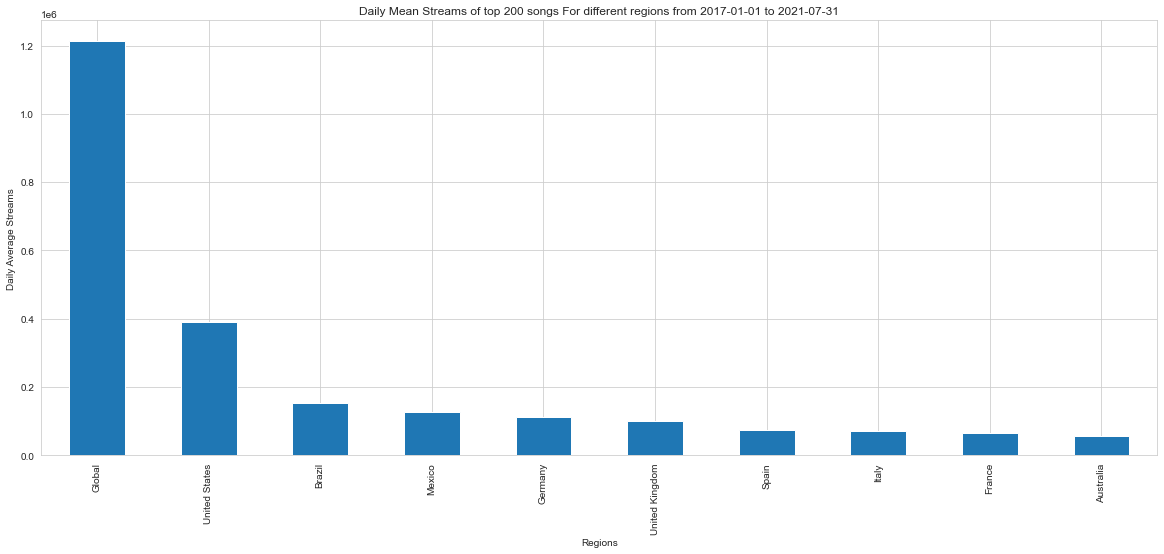

In [8]:
#Country with highest average stream
sns.set_style("whitegrid")
Reading_csv.groupby("region")["streams"].mean().sort_values(ascending=False)[0:10].plot.bar(figsize= (20,8))
plt.title("Daily Mean Streams of top 200 songs For different regions from 2017-01-01 to 2021-07-31")
plt.ylabel("Daily Average Streams")
plt.xlabel("Regions")

### These are the top 10 countries where spotify is used extensively, and hence we could narrow our search to only United States, Brazil, Mexico, Germany, United Kingdom, Spain, Italy, France and Australia

### Let us now see, the artists whose songs have been streamed the highest over 3 years

Text(0.5, 1.0, 'Top 25 songs, with highest streams averaged over 3 years')

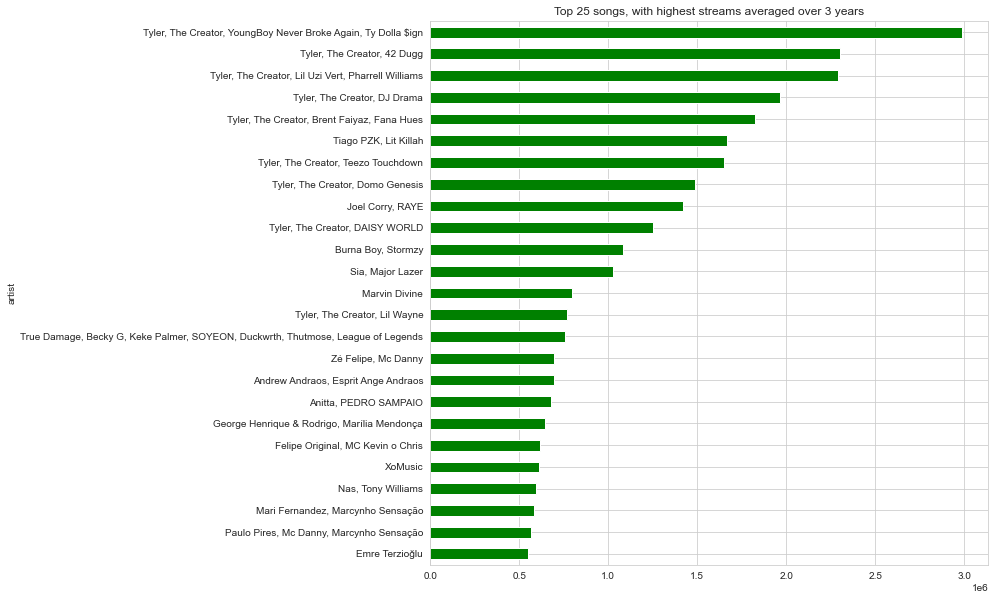

In [9]:
plt.figure(figsize=(10,10))
Reading_csv.groupby("artist")["streams"].mean().dropna().sort_values(ascending= True).tail(25).plot.barh(color="green")
plt.title("Top 25 songs, with highest streams averaged over 3 years")

### Next, lets see the daily avergage streams for different regions songs, falling in top 200

<AxesSubplot:title={'center':'Mean Streams of Songs featured in daily top 200 for different countries from 2017-01-01 to 2021-07-31'}, xlabel='region', ylabel='Mean Streams'>

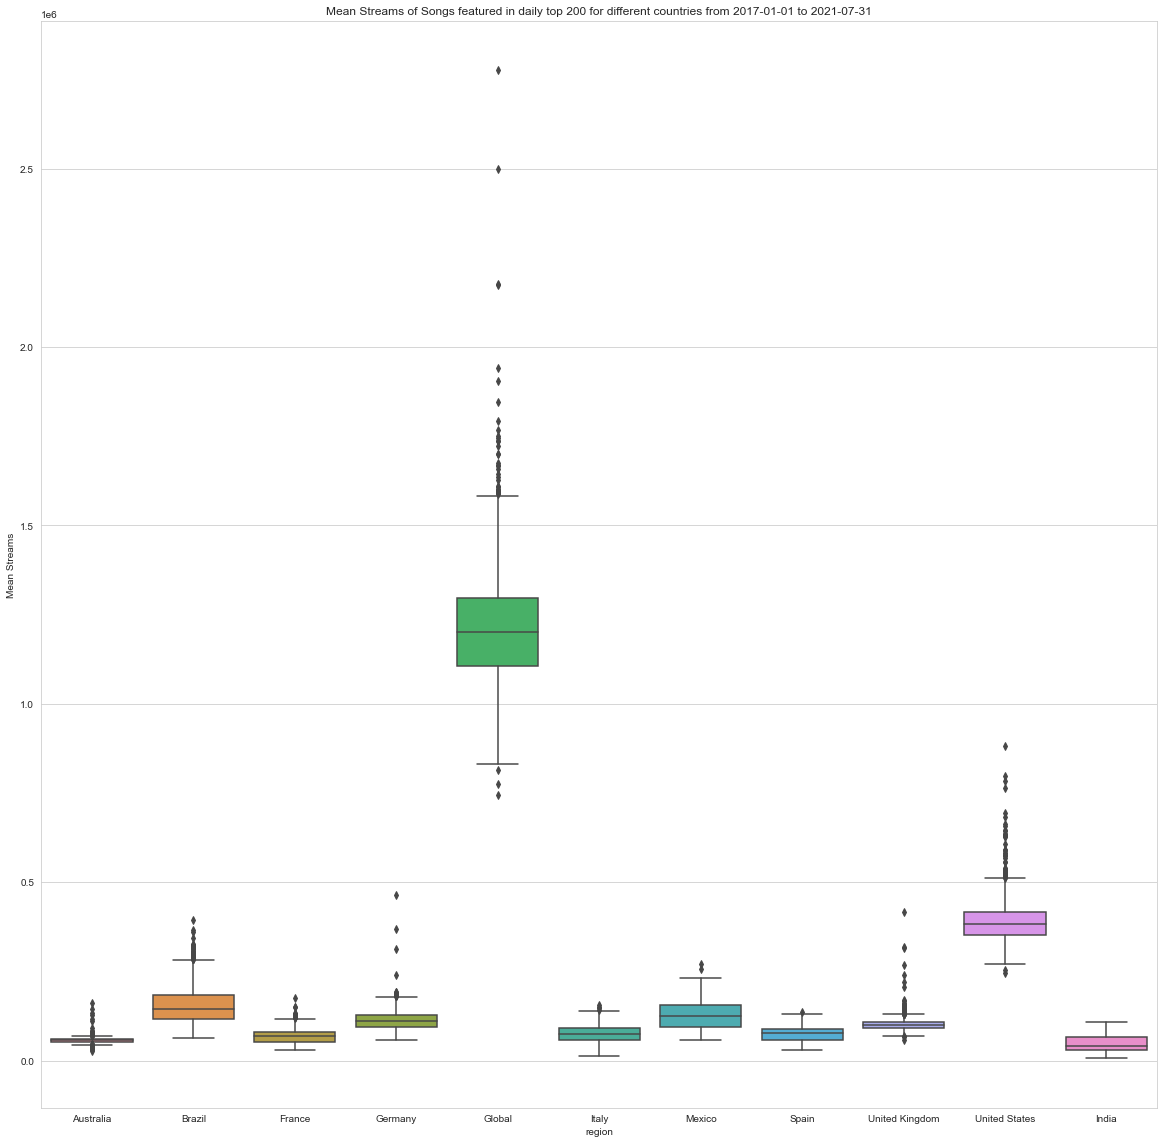

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,20))
plt.title("Mean Streams of Songs featured in daily top 200 for different countries from 2017-01-01 to 2021-07-31")
sns.boxplot(data=Country_wise_streams[(Country_wise_streams["region"]=="United Kingdom") | (Country_wise_streams["region"]=="United States") | (Country_wise_streams["region"]=="India")| (Country_wise_streams["region"]=="Global")| (Country_wise_streams["region"]=="Brazil")| (Country_wise_streams["region"]=="Mexico")| (Country_wise_streams["region"]=="Germany")| (Country_wise_streams["region"]=="Spain")| (Country_wise_streams["region"]=="Italy")| (Country_wise_streams["region"]=="France")| (Country_wise_streams["region"]=="Australia")],y="Mean Streams",x="region")

### The figure represents mean number of daily stream of top 200 songs, from 2017 until 2022 :- We see that global mean streams, has the highest value throughout the three years, followed by United States

### Lets see which artist will be the one whose songs are listened the most and hence will be driver, when it comes to sentiments, based on the kind of songs made 

In [11]:

def visualize_word_counts(counts):
    '''Function that takes counts of different atrist and generates a word cloud'''
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='white', 
                   prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate_from_frequencies(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [12]:
USA_WC = Reading_csv[Reading_csv["region"]=="United States"]["title"].value_counts()

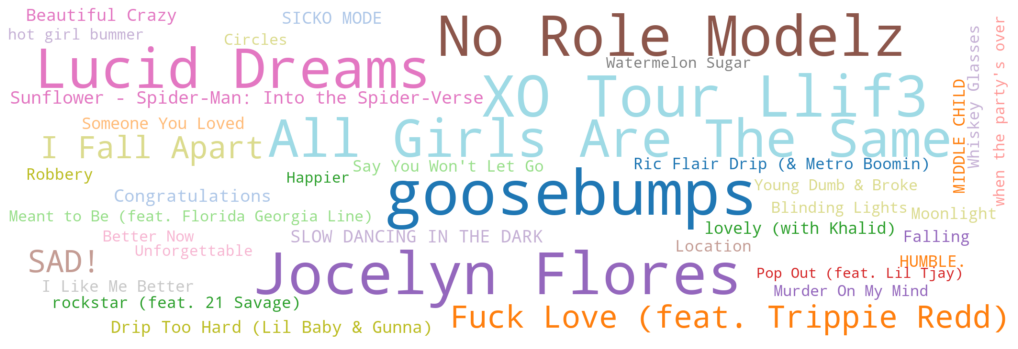

In [13]:
visualize_word_counts(USA_WC)

In [14]:
Brazil_WC = Reading_csv[Reading_csv["region"]=="Brazil"]["title"].value_counts()

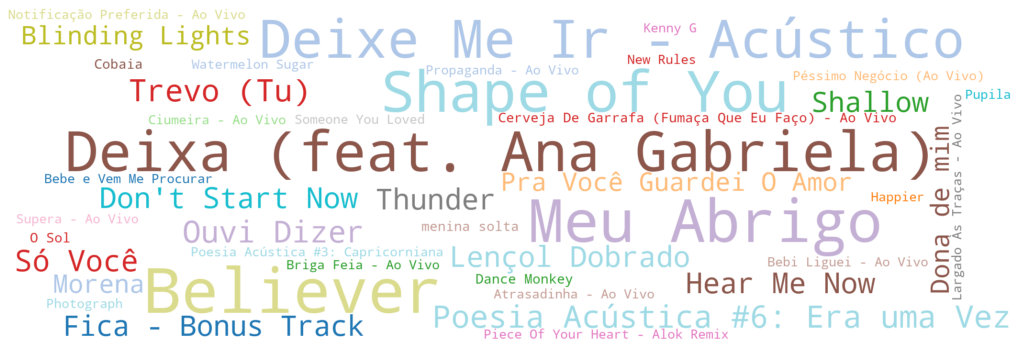

In [15]:
visualize_word_counts(Brazil_WC)

In [16]:
Mexico_WC = Reading_csv[Reading_csv["region"]=="Mexico"]["title"].value_counts()

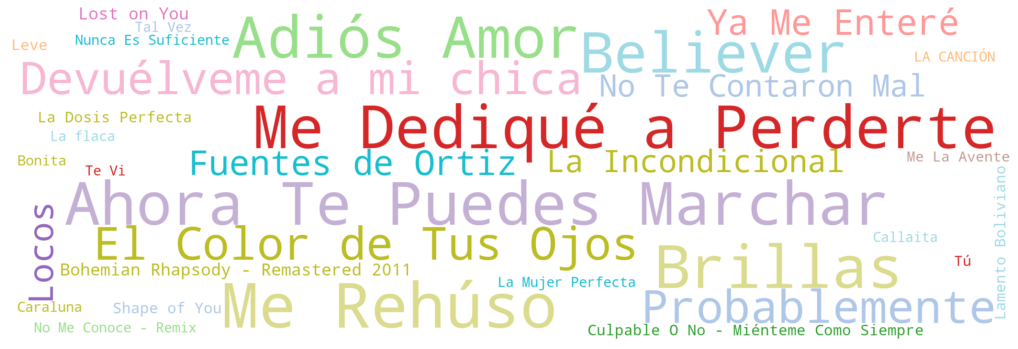

In [17]:
visualize_word_counts(Mexico_WC)

### In order to get the valence score for the imported songs we need to make spotify API calls. Valence is the indicator, which is evaluated by music experts at spotify and its value ranges from 0 to 1, 0 meaning sad song, while 1 meaning happy song

### Lets set-up the credentials, which we will be used to make the API calls in future

In [18]:
#importing necessary packages
import seaborn as sns
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
#Client ID, obtained from the dashboard
SPOTIPY_CLIENT_ID='854e31ffce144cd6bb8d6f6332126cf5'
#Client secret, obtained from the dashboard
SPOTIPY_CLIENT_SECRET= '2b82b02c8a27408790065f416daf5c3f'
#creating a sp object, which will be called to query required spotify data
auth_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)
sp.me

<bound method Spotify.me of <spotipy.client.Spotify object at 0x0000028B423C1040>>

### Data Preparation :- Getting Country-wise Valence score of top 3 regions, where spotify is widely used, which are :- 
#### 1. United States
#### 2. Brazil
#### 3. Mexico


### Lets Get the indicators of songs

In [19]:
#applying REGEX to get th Uri from the url column and saving it in a new column nammed "id"
Reading_csv['id'] = Reading_csv['url'].apply(lambda x: re.findall('([0-9][\s\S]*)$',x)[0])

### Function to get valence data, for the requested country

In [20]:
def valence_df(df,country):
    country_top200 = df[df["region"]==f"{country}"]
    # The data will have songs repeated, and so will the track id, its better to get the unique track id and make calls to spotify API to save time
    country_uniq_url = country_top200["id"].unique()
    #for track in audio_features:
     #features.append(track)
    features = []
    for i in tqdm(country_uniq_url):
        audio_features = sp.audio_features(i)[0]
        features.append(audio_features)
    features = [i for i in features if i is not None]
    features_df = pd.DataFrame(features) 
    #to get the songs feature added to the previous dataframe
    country_songs_df= pd.merge(features_df, country_top200, on='id', how='inner')
    #saving the dataframe locally, as the above opertion is time taking
    country_songs_df.to_csv(f"{country}_song_df.csv")

### In future, we need to call the function named valence_df, to get a dataframe, with song features along with other details of the song

In [146]:
valence_df(Reading_csv,"Mexico")
#valence_df(Reading_csv,"Brazil")
#valence_df(Reading_csv,"United States")

100%|██████████| 7836/7836 [11:27<00:00, 11.40it/s]  


### Lets load the dataset for the three countries :- These datasets, have been saved in local after running the above code, so that in future data-retrieval is easy

In [21]:
mexico_song_df = pd.read_csv("Mexico_song_df.csv")

In [22]:
brazil_song_df = pd.read_csv("Brazil_song_df.csv")

In [23]:
USA_song_df = pd.read_csv("USA_song_df.csv")

### Lets get the valence associated with the artist of USA, whose songs are featured in daily top 200, for most of the times, as seen in the wordcloud

In [25]:
MV_USA = pd.DataFrame(USA_song_df.groupby("title")["valence"].mean()).reset_index()
MV_USA[(MV_USA["title"]=="goosebumps") | (MV_USA["title"]=="Lucid Dreams")| (MV_USA["title"]=="No Role Modelz")|(MV_USA["title"]=="All Girls Are The Same")|(MV_USA["title"]=="Jocelyn Flores")]


title   valence
481    All Girls Are The Same  0.203644
5142           Jocelyn Flores  0.437000
5999             Lucid Dreams  0.218094
6907           No Role Modelz  0.463000
11539              goosebumps  0.430000

### Lets get the valence associated with the artist of Brazil, whose songs are featured in daily top 200, for most of the times, as seen in the wordcloud

In [29]:
MV_Brazil = pd.DataFrame(brazil_song_df.groupby("title")["valence"].mean()).reset_index()
MV_Brazil[(MV_Brazil["title"]=="Shape of You") | (MV_Brazil["title"]=="Believer")| (MV_Brazil["title"]=="Meu Abrigo")|(MV_Brazil["title"]=="Deixa (feat. Ana Gabriela)")|(MV_Brazil["title"]=="Trevo (Tu)")]


title   valence
894                     Believer  0.680153
1838  Deixa (feat. Ana Gabriela)  0.331000
4230                  Meu Abrigo  0.740443
6207                Shape of You  0.930678
7047                  Trevo (Tu)  0.223406

### Lets get the valence associated with the artist of Mexico, whose songs are featured in daily top 200, for most of the times, as seen in the wordcloud

In [35]:
MV_Mexico = pd.DataFrame(mexico_song_df.groupby("title")["valence"].mean()).reset_index()
MV_Mexico[(MV_Mexico["title"]=="Ahora Te Puedes Marchar") | (MV_Mexico["title"]=="Me Rehuso")| (MV_Mexico["title"]=="Brillas")|(MV_Mexico["title"]=="Believer")|(MV_Mexico["title"]=="Adios Amor")]


title   valence
188                Adios Amor  0.711000
227   Ahora Te Puedes Marchar  0.909527
631                  Believer  0.679383
776                   Brillas  0.274000
3490                Me Rehuso  0.553000

In [1211]:
USA_song_df["date"] = pd.to_datetime(USA_song_df["date"])

In [1212]:
mexico_song_df["date"] = pd.to_datetime(mexico_song_df["date"])

In [1213]:
brazil_song_df["date"] = pd.to_datetime(brazil_song_df["date"])

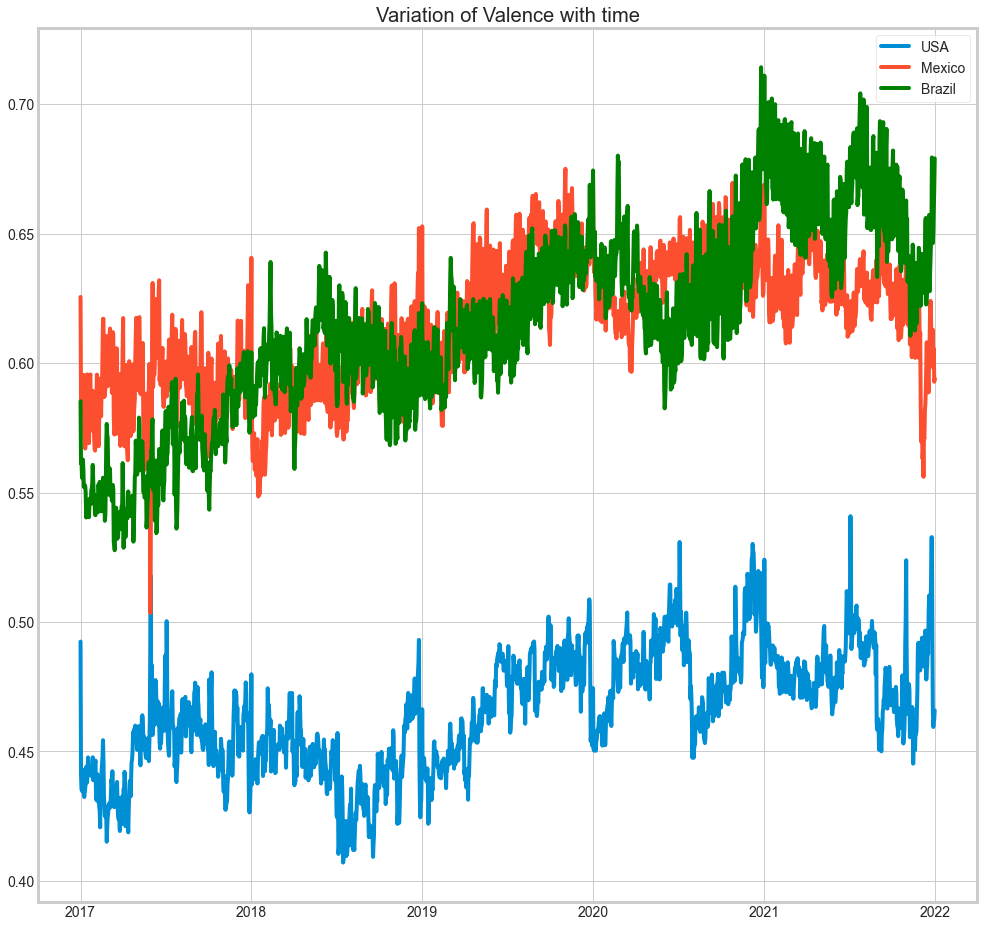

In [1214]:
plt.figure(figsize=(15,15))
plt.plot(USA_song_df[["valence","date"]].set_index("date").groupby("date").mean(), label="USA")
plt.plot(mexico_song_df[["valence","date"]].set_index("date").groupby("date").mean(),label="Mexico")
plt.plot(brazil_song_df[["valence","date"]].set_index("date").groupby("date").mean(),label="Brazil", color="green")
plt.title("Variation of Valence with time")
plt.legend()

In [1215]:
USA_song_df.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'url', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'title', 'rank', 'date', 'artist',
       'region', 'chart', 'trend', 'streams'],
      dtype='object')

### We first begin by analyzing USA dataset, by seeing its correlation with NASDAQ daily data

### Lets see the first few rows of the prepared USA, daily top 200 data, from 2017 to 2021

In [1216]:
USA_song_df.head()

Unnamed: 0  danceability  energy  key  loudness  mode  speechiness  \
0           0         0.926   0.666   11    -5.314     1       0.2440   
1       27418         0.762   0.666    0    -6.055     1       0.0916   
2       27409         0.611   0.700    9    -5.331     1       0.0436   
3       27354         0.595   0.662   11    -6.858     0       0.0362   
4       27279         0.569   0.761    5    -6.071     0       0.4750   

   acousticness  instrumentalness  liveness  ...  duration_ms  time_signature  \
0       0.06110          0.000000    0.1230  ...       343150               4   
1       0.00427          0.000000    0.1270  ...       232093               4   
2       0.01990          0.000000    0.0549  ...       220573               4   
3       0.01780          0.000000    0.0804  ...       218447               4   
4       0.26100          0.000007    0.0748  ...       184000               4   

                                 title rank       date  \
0  Bad and Boujee (feat. Lil Uzi Vert)    1 2017-01-01   
1                        Really Really  185 2017-01-01   
2                               Middle  184 2017-01-01   
3          Lighthouse - Andrelli Remix  183 2017-01-01   
4         Timeless (feat. DJ SPINKING)  182 2017-01-01   

                       artist         region   chart          trend    streams  
0                       Migos  United States  top200  SAME_POSITION  1371493.0  
1                 Kevin Gates  United States  top200      MOVE_DOWN   149053.0  
2  DJ Snake, Bipolar Sunshine  United States  top200      MOVE_DOWN   149265.0  
3             Hearts & Colors  United States  top200      MOVE_DOWN   149929.0  
4      A Boogie Wit da Hoodie  United States  top200      MOVE_DOWN   150458.0  

[5 rows x 27 columns]

### We have the following columns in the dataset

In [1217]:
USA_song_df.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'url', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'title', 'rank', 'date', 'artist',
       'region', 'chart', 'trend', 'streams'],
      dtype='object')

### Lets get only few columns, which will be helpful in studying the data further

In [1218]:
df = USA_song_df.groupby("date")[["valence","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","tempo"]].mean()
df_Br = brazil_song_df.groupby("date")[["valence","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","tempo"]].mean()
df_Me = mexico_song_df.groupby("date")[["valence","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","tempo"]].mean()

In [1219]:
#printing the value as data-frame
df = df.reset_index()
df_Br = df_Br.reset_index()
df_Me = df_Me.reset_index()
df = df.rename(columns={"date": "Date"})
df_Br = df_Br.rename(columns={"date": "Date"})
df_Me = df_Me.rename(columns={"date": "Date"})



### NASDAQ data

In [1220]:
import pandas_datareader as pdr
import datetime as dt
ticker = "NQ=F"
start= dt.datetime (2017, 1, 1)
end= dt.datetime (2021, 12, 31)
data_NASDAQ = pdr.get_data_yahoo(ticker, start,end)
data_NASDAQ.head()

High      Low     Open    Close  Volume  Adj Close
Date                                                             
2017-01-03  4927.50  4876.75  4876.75  4906.25  215983    4906.25
2017-01-04  4942.50  4903.00  4906.50  4933.50  171952    4933.50
2017-01-05  4964.25  4920.50  4934.75  4962.00  169565    4962.00
2017-01-06  5017.50  4952.50  4962.50  5004.00  183315    5004.00
2017-01-09  5029.50  5002.50  5004.50  5022.00  148112    5022.00

In [1221]:
NASDAQ_data= pd.merge(df, data_NASDAQ, on ="Date", how ="inner")
NASDAQ_data = NASDAQ_data.set_index("Date")

### Lets get the final dataset for NASDAQ

In [1256]:
NASDAQ_data.head()

valence  danceability    energy    key  loudness   mode  \
Date                                                                   
2017-01-03  0.435576      0.666648  0.600927  5.228 -7.112056  0.536   
2017-01-04  0.434716      0.666992  0.605056  5.204 -6.992640  0.544   
2017-01-05  0.439952      0.670932  0.604552  5.236 -6.934576  0.540   
2017-01-06  0.438108      0.667940  0.598776  5.208 -6.957628  0.536   
2017-01-09  0.432372      0.658476  0.589656  5.084 -7.009332  0.604   

            speechiness  acousticness  instrumentalness  liveness       tempo  \
Date                                                                            
2017-01-03     0.135756      0.218104          0.016552  0.164992  121.103244   
2017-01-04     0.136420      0.220454          0.016665  0.167797  122.253008   
2017-01-05     0.138137      0.223657          0.018135  0.170918  122.224648   
2017-01-06     0.136861      0.237315          0.019336  0.166951  121.565448   
2017-01-09     0.142519      0.247206          0.020330  0.167113  120.864644   

               High      Low     Open    Close  Volume  Adj Close  
Date                                                               
2017-01-03  4927.50  4876.75  4876.75  4906.25  215983    4906.25  
2017-01-04  4942.50  4903.00  4906.50  4933.50  171952    4933.50  
2017-01-05  4964.25  4920.50  4934.75  4962.00  169565    4962.00  
2017-01-06  5017.50  4952.50  4962.50  5004.00  183315    5004.00  
2017-01-09  5029.50  5002.50  5004.50  5022.00  148112    5022.00

Text(0.5, 1.0, 'Heatmap between song features and NASDAQ Adjusted Close')

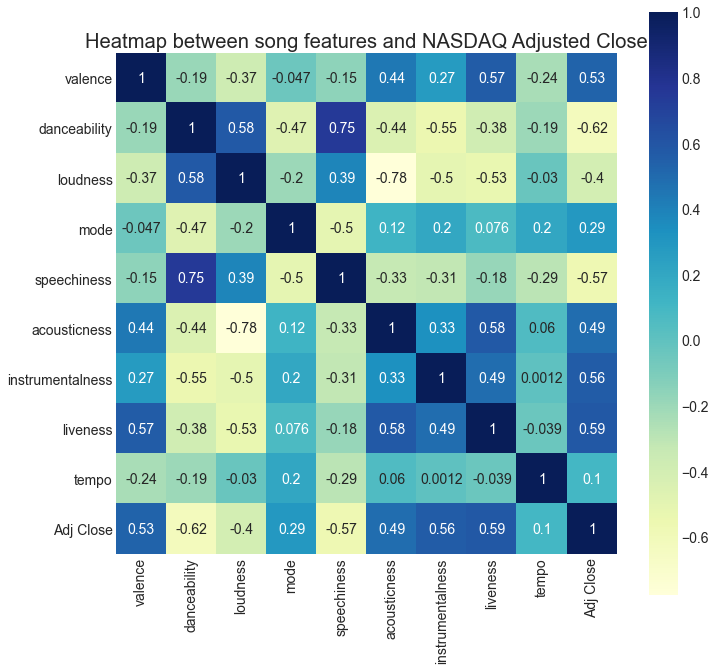

In [1239]:
# Calculate correlation between each pair of variable
corr_matrix=NASDAQ_data.drop(columns = ["High","Low","Open","Volume","Close","key","energy"]).corr()
sns.heatmap(corr_matrix, square=True,cmap="YlGnBu",annot= True)
plt.title("Heatmap between song features and NASDAQ Adjusted Close")

In [1240]:
normalized_df_USA = (NASDAQ_data-NASDAQ_data.mean())/NASDAQ_data.std()

''

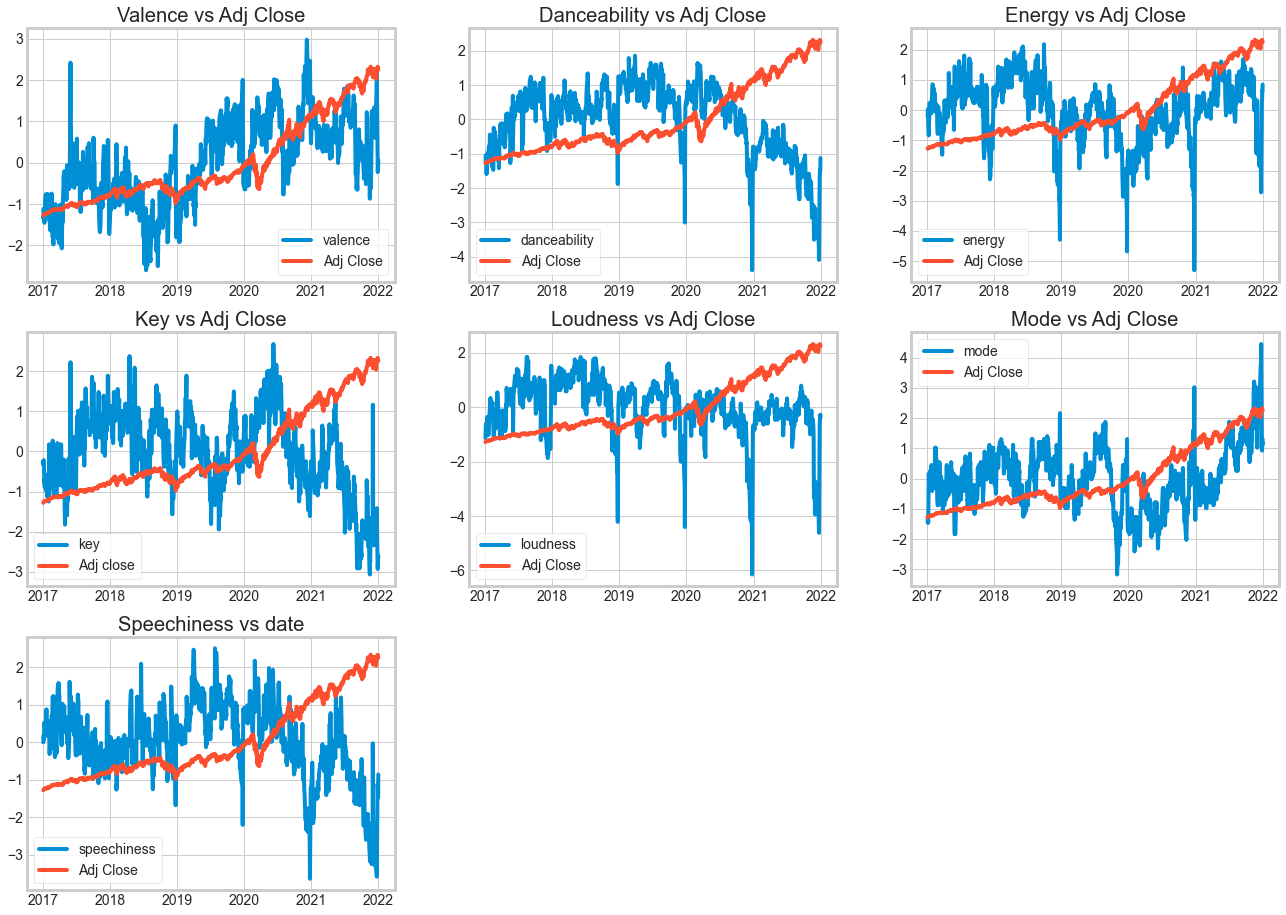

In [1241]:
plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
plt.plot(normalized_df_USA["valence"],label="valence")
plt.plot(normalized_df_USA["Adj Close"],label="Adj Close")
plt.title('Valence vs Adj Close')
plt.legend()
plt.subplot(4,3,2)
plt.plot(normalized_df_USA["danceability"],label="danceability")
plt.plot(normalized_df_USA["Adj Close"],label="Adj Close")
plt.title('Danceability vs Adj Close')
plt.legend()
plt.subplot(4,3,3)
plt.plot(normalized_df_USA["energy"], label="energy",)
plt.plot(normalized_df_USA["Adj Close"], label= "Adj Close")
plt.title("Energy vs Adj Close")
plt.legend()
plt.subplot(4,3,4)
plt.plot(normalized_df_USA["key"],label="key")
plt.plot(normalized_df_USA["Adj Close"], label ="Adj close")
plt.title("Key vs Adj Close")
plt.legend()
plt.subplot(4,3,5)
plt.plot(normalized_df_USA["loudness"],label="loudness")
plt.plot(normalized_df_USA["Adj Close"],label="Adj Close")
plt.title("Loudness vs Adj Close")
plt.legend()
plt.subplot(4,3,6)
plt.plot(normalized_df_USA["mode"], label="mode")
plt.plot(normalized_df_USA["Adj Close"], label ="Adj Close")
plt.title("Mode vs Adj Close")
plt.legend()
plt.subplot(4,3,7)
plt.plot(normalized_df_USA["speechiness"], label="speechiness")
plt.plot(normalized_df_USA["Adj Close"], label = "Adj Close")
plt.title('Speechiness vs date')
plt.legend()

;


### Lets run the same code for Sao Paolo dataset

In [1242]:

import pandas_datareader as pdr
import datetime as dt
ticker = "^BVSP"
start= dt.datetime (2017, 1, 1)
end= dt.datetime (2021, 12, 31)
data_BVSP = pdr.get_data_yahoo(ticker, start,end)
data_BVSP.head()

High      Low     Open    Close     Volume  Adj Close
Date                                                                
2017-01-02  60227.0  59371.0  60227.0  59589.0   808700.0    59589.0
2017-01-03  61815.0  59631.0  59631.0  61814.0  3328300.0    61814.0
2017-01-04  61940.0  61302.0  61811.0  61589.0  2840800.0    61589.0
2017-01-05  62409.0  61594.0  61594.0  62071.0  3313000.0    62071.0
2017-01-06  62072.0  61396.0  62072.0  61665.0  2374800.0    61665.0

In [1243]:
BVSP_data= pd.merge(df_Br, data_BVSP, on ="Date", how ="inner")
BVSP_data = BVSP_data.set_index("Date")

In [1244]:
BVSP_data.head()

valence  danceability    energy    key  loudness   mode  \
Date                                                                   
2017-01-02  0.561237      0.668816  0.708891  5.436 -5.445044  0.544   
2017-01-03  0.562969      0.670508  0.709091  5.472 -5.439364  0.564   
2017-01-04  0.556461      0.669932  0.705623  5.404 -5.472388  0.572   
2017-01-05  0.555457      0.668360  0.713868  5.408 -5.351492  0.580   
2017-01-06  0.562745      0.667468  0.719204  5.352 -5.290128  0.560   

            speechiness  acousticness  instrumentalness  liveness       tempo  \
Date                                                                            
2017-01-02     0.102524      0.282923          0.006192  0.270478  124.175512   
2017-01-03     0.103570      0.281372          0.006192  0.265586  124.462860   
2017-01-04     0.101104      0.282005          0.010675  0.261606  124.489848   
2017-01-05     0.100922      0.271508          0.008665  0.261219  124.562884   
2017-01-06     0.097914      0.278140          0.010253  0.263884  125.605220   

               High      Low     Open    Close     Volume  Adj Close  
Date                                                                  
2017-01-02  60227.0  59371.0  60227.0  59589.0   808700.0    59589.0  
2017-01-03  61815.0  59631.0  59631.0  61814.0  3328300.0    61814.0  
2017-01-04  61940.0  61302.0  61811.0  61589.0  2840800.0    61589.0  
2017-01-05  62409.0  61594.0  61594.0  62071.0  3313000.0    62071.0  
2017-01-06  62072.0  61396.0  62072.0  61665.0  2374800.0    61665.0

Text(0.5, 1.0, 'Heatmap between song features and Sao Paulo Adjusted Close')

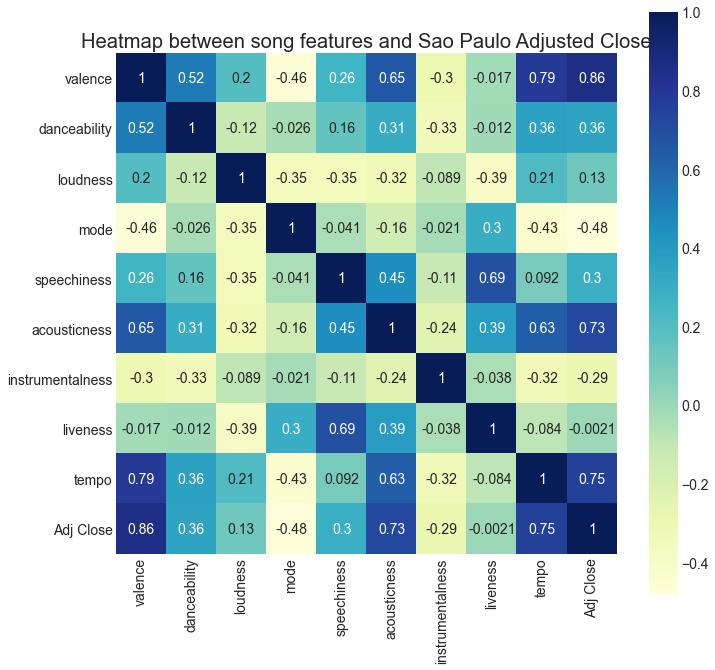

In [1247]:
# Calculate correlation between each pair of variable
corr_matrix=BVSP_data.drop(columns = ["High","Low","Open","Volume","Close","key","energy"]).corr()
sns.heatmap(corr_matrix, square=True,cmap="YlGnBu",annot=True)
plt.title("Heatmap between song features and Sao Paulo Adjusted Close")

In [1248]:
normalized_df_Brazil = (BVSP_data-BVSP_data.mean())/BVSP_data.std()

''

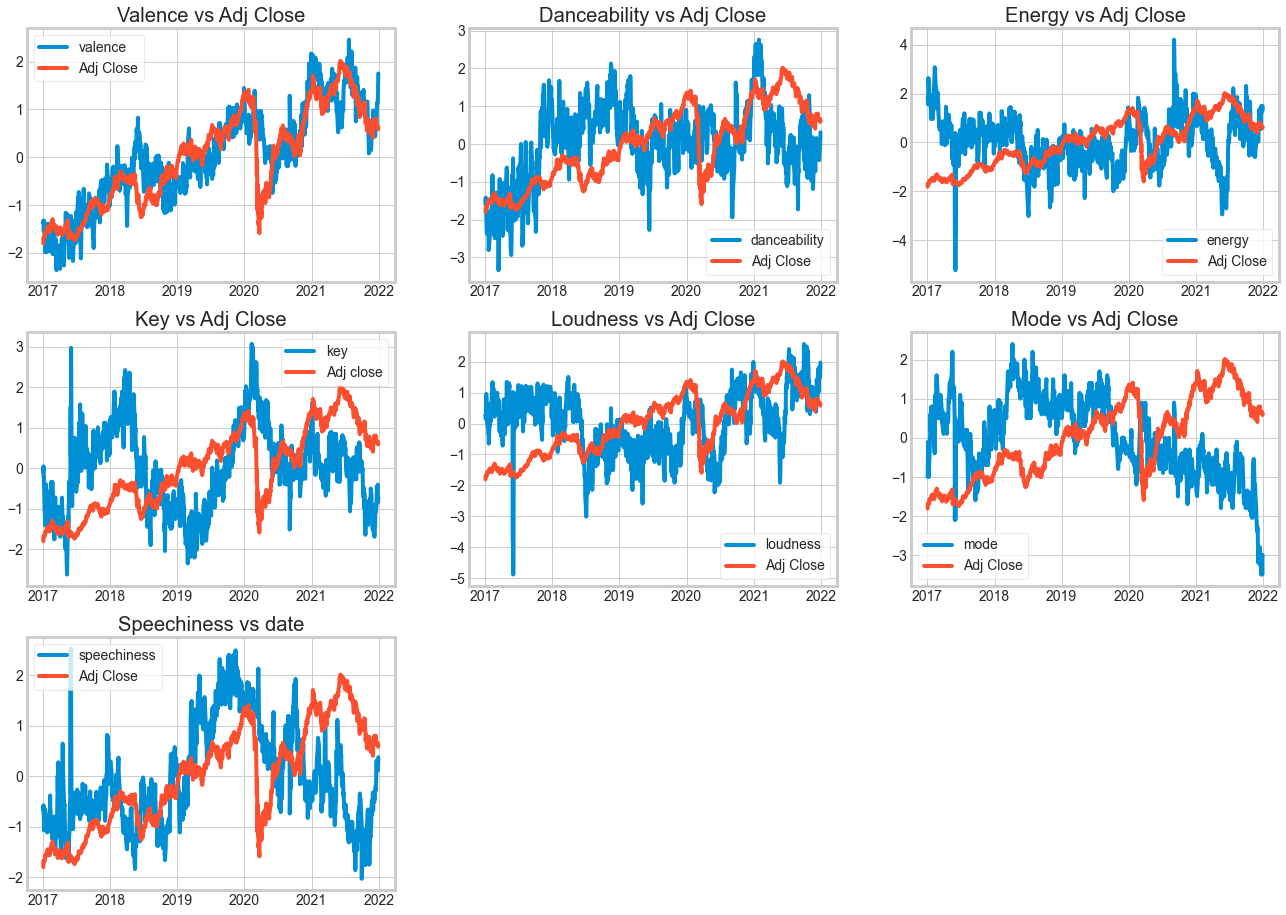

In [1249]:
plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
plt.plot(normalized_df_Brazil["valence"],label="valence")
plt.plot(normalized_df_Brazil["Adj Close"],label="Adj Close")
plt.title('Valence vs Adj Close')
plt.legend()
plt.subplot(4,3,2)
plt.plot(normalized_df_Brazil["danceability"],label="danceability")
plt.plot(normalized_df_Brazil["Adj Close"],label="Adj Close")
plt.title('Danceability vs Adj Close')
plt.legend()
plt.subplot(4,3,3)
plt.plot(normalized_df_Brazil["energy"], label="energy",)
plt.plot(normalized_df_Brazil["Adj Close"], label= "Adj Close")
plt.title("Energy vs Adj Close")
plt.legend()
plt.subplot(4,3,4)
plt.plot(normalized_df_Brazil["key"],label="key")
plt.plot(normalized_df_Brazil["Adj Close"], label ="Adj close")
plt.title("Key vs Adj Close")
plt.legend()
plt.subplot(4,3,5)
plt.plot(normalized_df_Brazil["loudness"],label="loudness")
plt.plot(normalized_df_Brazil["Adj Close"],label="Adj Close")
plt.title("Loudness vs Adj Close")
plt.legend()
plt.subplot(4,3,6)
plt.plot(normalized_df_Brazil["mode"], label="mode")
plt.plot(normalized_df_Brazil["Adj Close"], label ="Adj Close")
plt.title("Mode vs Adj Close")
plt.legend()
plt.subplot(4,3,7)
plt.plot(normalized_df_Brazil["speechiness"], label="speechiness")
plt.plot(normalized_df_Brazil["Adj Close"], label = "Adj Close")
plt.title('Speechiness vs date')
plt.legend()

;


### lets run the same code for IPC mexico

In [1250]:
import pandas_datareader as pdr
import datetime as dt
ticker = "^MXX"
start= dt.datetime (2017, 1, 1)
end= dt.datetime (2021, 12, 31)
data_IPC = pdr.get_data_yahoo(ticker, start,end)
data_IPC.head()

High           Low          Open         Close     Volume  \
Date                                                                            
2017-01-02  45792.460938  45593.261719  45642.800781  45695.101562    6765800   
2017-01-03  46444.718750  45690.460938  45698.929688  46123.359375  164938800   
2017-01-04  46587.738281  46068.828125  46123.359375  46587.738281  215385900   
2017-01-05  46767.371094  46285.878906  46586.031250  46719.988281  237288300   
2017-01-06  46731.898438  46027.101562  46721.699219  46071.570312  201371200   

               Adj Close  
Date                      
2017-01-02  45695.101562  
2017-01-03  46123.359375  
2017-01-04  46587.738281  
2017-01-05  46719.988281  
2017-01-06  46071.570312

In [1251]:
IPC_data= pd.merge(df_Me, data_IPC, on ="Date", how ="inner")
IPC_data = IPC_data.set_index("Date")

In [1252]:
IPC_data.head()

valence  danceability    energy    key  loudness   mode  \
Date                                                                   
2017-01-02  0.585720      0.675200  0.675204  5.416 -5.779620  0.584   
2017-01-03  0.582374      0.670608  0.678592  5.428 -5.724452  0.588   
2017-01-04  0.580791      0.670200  0.670344  5.372 -5.821972  0.588   
2017-01-05  0.581730      0.668472  0.677216  5.364 -5.772284  0.608   
2017-01-06  0.584703      0.670516  0.675320  5.328 -5.816628  0.608   

            speechiness  acousticness  instrumentalness  liveness       tempo  \
Date                                                                            
2017-01-02     0.093942      0.244465          0.008340  0.178525  122.704680   
2017-01-03     0.096342      0.248047          0.005052  0.185325  123.742536   
2017-01-04     0.093654      0.249828          0.004319  0.185209  123.280012   
2017-01-05     0.092450      0.245710          0.005082  0.186512  122.383892   
2017-01-06     0.094268      0.245267          0.009881  0.187562  123.015948   

                    High           Low          Open         Close     Volume  \
Date                                                                            
2017-01-02  45792.460938  45593.261719  45642.800781  45695.101562    6765800   
2017-01-03  46444.718750  45690.460938  45698.929688  46123.359375  164938800   
2017-01-04  46587.738281  46068.828125  46123.359375  46587.738281  215385900   
2017-01-05  46767.371094  46285.878906  46586.031250  46719.988281  237288300   
2017-01-06  46731.898438  46027.101562  46721.699219  46071.570312  201371200   

               Adj Close  
Date                      
2017-01-02  45695.101562  
2017-01-03  46123.359375  
2017-01-04  46587.738281  
2017-01-05  46719.988281  
2017-01-06  46071.570312

Text(0.5, 1.0, 'Heatmap between song features and IPC Mexico Adjusted Close')

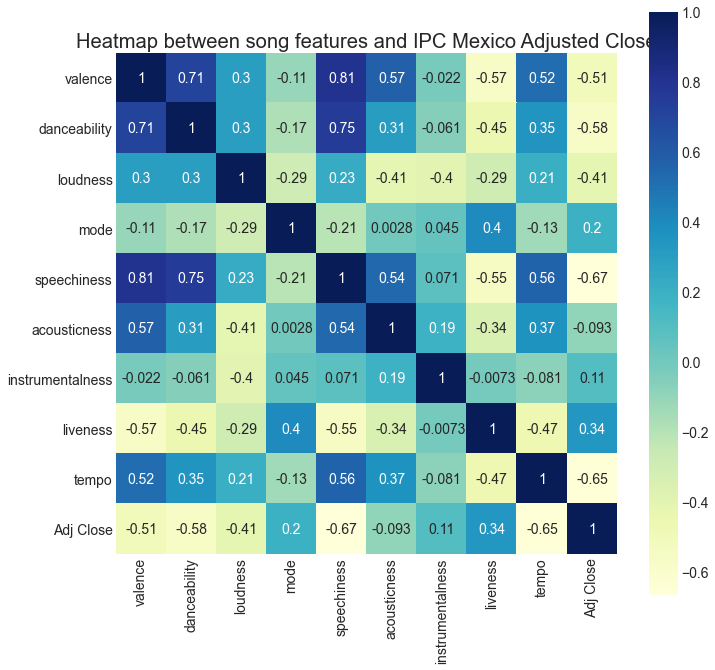

In [1253]:
# Calculate correlation between each pair of variable
corr_matrix=IPC_data.drop(columns = ["High","Low","Open","Volume","Close","key","energy"]).corr()
sns.heatmap(corr_matrix, square=True,cmap="YlGnBu",annot=True)
plt.title("Heatmap between song features and IPC Mexico Adjusted Close")

In [1254]:
normalized_df_mexico = (IPC_data-IPC_data.mean())/IPC_data.std()

''

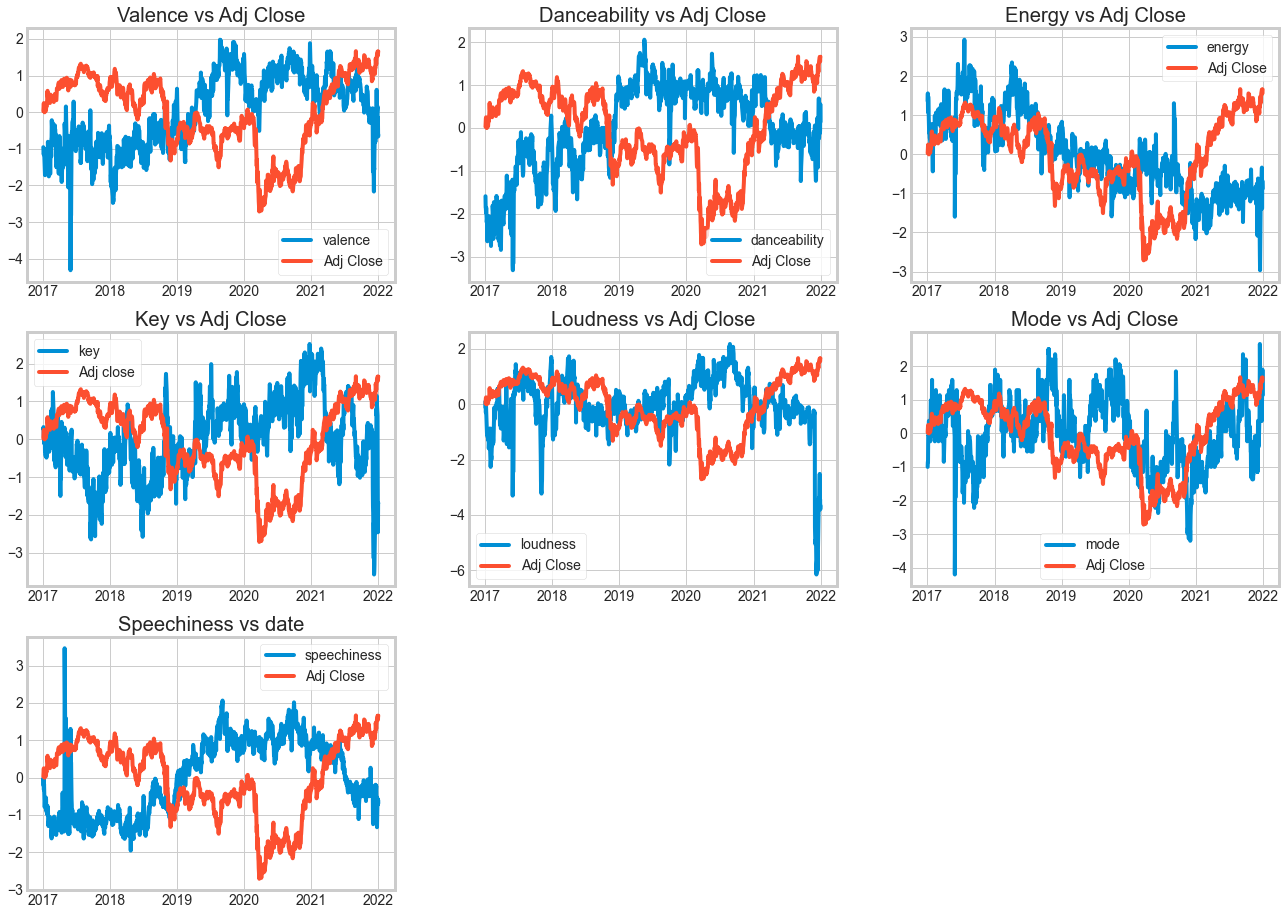

In [1255]:
plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
plt.plot(normalized_df_mexico["valence"],label="valence")
plt.plot(normalized_df_mexico["Adj Close"],label="Adj Close")
plt.title('Valence vs Adj Close')
plt.legend()
plt.subplot(4,3,2)
plt.plot(normalized_df_mexico["danceability"],label="danceability")
plt.plot(normalized_df_mexico["Adj Close"],label="Adj Close")
plt.title('Danceability vs Adj Close')
plt.legend()
plt.subplot(4,3,3)
plt.plot(normalized_df_mexico["energy"], label="energy",)
plt.plot(normalized_df_mexico["Adj Close"], label= "Adj Close")
plt.title("Energy vs Adj Close")
plt.legend()
plt.subplot(4,3,4)
plt.plot(normalized_df_mexico["key"],label="key")
plt.plot(normalized_df_mexico["Adj Close"], label ="Adj close")
plt.title("Key vs Adj Close")
plt.legend()
plt.subplot(4,3,5)
plt.plot(normalized_df_mexico["loudness"],label="loudness")
plt.plot(normalized_df_mexico["Adj Close"],label="Adj Close")
plt.title("Loudness vs Adj Close")
plt.legend()
plt.subplot(4,3,6)
plt.plot(normalized_df_mexico["mode"], label="mode")
plt.plot(normalized_df_mexico["Adj Close"], label ="Adj Close")
plt.title("Mode vs Adj Close")
plt.legend()
plt.subplot(4,3,7)
plt.plot(normalized_df_mexico["speechiness"], label="speechiness")
plt.plot(normalized_df_mexico["Adj Close"], label = "Adj Close")
plt.title('Speechiness vs date')
plt.legend()

;


### In the subsequent block of codes, we will be making a forecasting model for the ADJ close value of the NASDAQ, by adding the effect of exogeneous variable obtained from the spotify dataset

### Lets explore the NASDAQ, ADJ close value

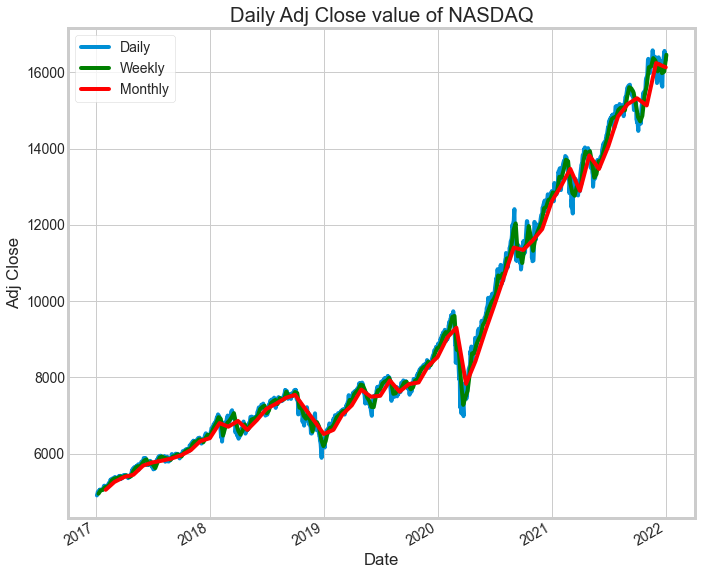

In [1607]:
plt.figure(figsize=(10,10))
NASDAQ_data["Adj Close"].plot(label="Daily")
NASDAQ_data["Adj Close"].resample("W").mean().plot(label="Weekly",color="green")
NASDAQ_data["Adj Close"].resample("M").mean().plot(label="Monthly",color="red")
plt.title("Daily Adj Close value of NASDAQ")
plt.ylabel("Adj Close")
plt.legend()

### We can see the effect of smoothening, with blue line representing the ADJ close daily, while red line, representing the monthly aggregate. Also, we will be using weekly aggregated data for further analysis

In [1518]:
y = NASDAQ_data["Adj Close"].resample("W").mean()


''

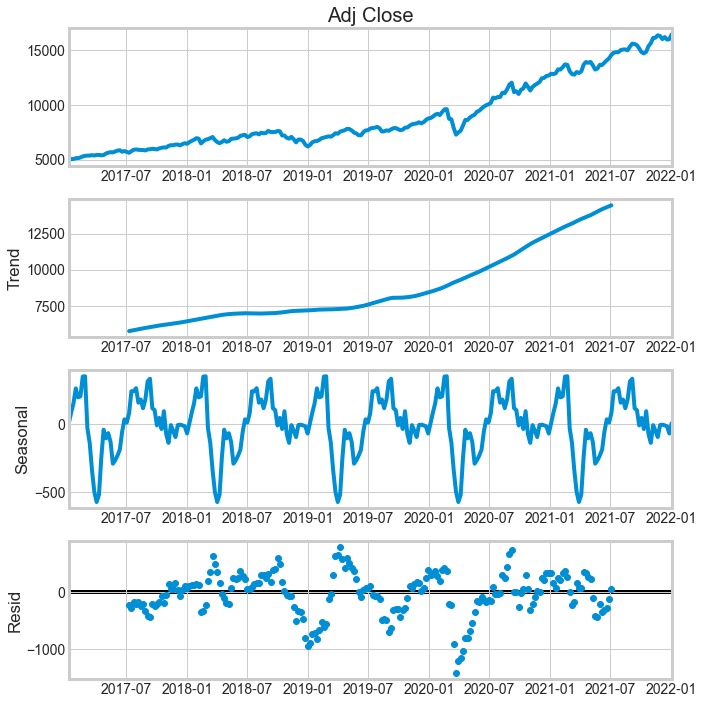

In [1519]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y.dropna(), model="additive")
plt.rcParams.update({'figure.figsize': (10,10)})
decomposition.plot()
;

### We can, see that there is clear increasing trend in the graph and so we need to make it stationary, in order to be sure, we need to perform a statistical test called ADF test

In [1520]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [1521]:
adf_test(NASDAQ_data["Adj Close"].resample("W").mean())

Results of Dickey-Fuller Test:
Test Statistic                   1.836525
p-value                          0.998419
#Lags Used                       5.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64


### We need to difference the series, and re-evaluate the ADF 

In [1522]:
NASDAQ_data["Adj Close"].resample("W").mean().diff().dropna()

Date
2017-01-15     87.712500
2017-01-22     12.475000
2017-01-29     71.675000
2017-02-05     11.050000
2017-02-12     58.600000
                 ...    
2021-12-05   -279.650000
2021-12-12    182.850000
2021-12-19   -229.785937
2021-12-26     40.985937
2022-01-02    440.400000
Freq: W-SUN, Name: Adj Close, Length: 260, dtype: float64

In [1523]:
#first differencing,gives the following result
Z = NASDAQ_data["Adj Close"].resample("W").mean().diff().dropna()

''

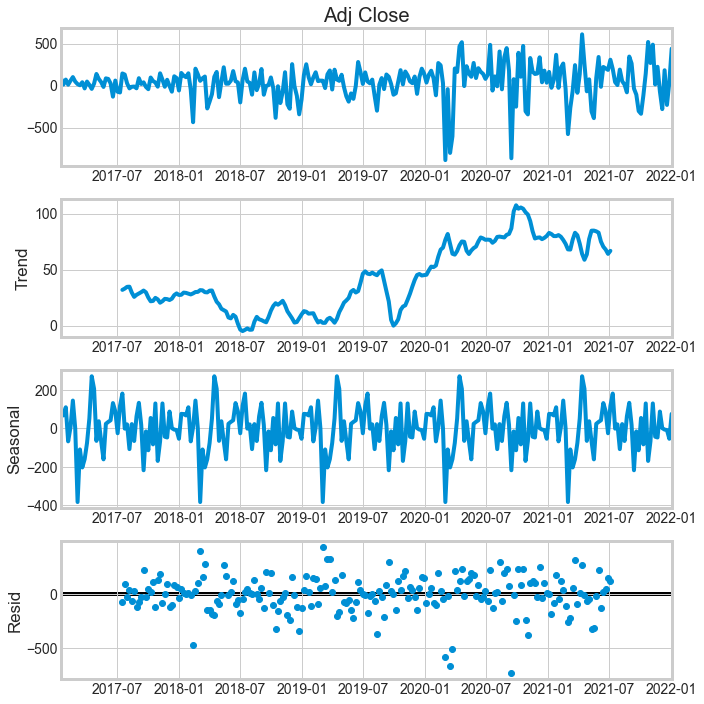

In [1524]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(Z, model="additive")
decomposition.plot()
;

### After differencing the time-series, we can see in the seasonal decomposition that the trend is no longer perceptible, and the seasonal component too is lost

In [1525]:
#Lets see the output of ADF after first differencing, 
adf_test(NASDAQ_data["Adj Close"].resample("W").mean().diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.112510e+00
p-value                        3.369763e-15
#Lags Used                     4.000000e+00
Number of Observations Used    2.550000e+02
Critical Value (1%)           -3.456257e+00
Critical Value (5%)           -2.872942e+00
Critical Value (10%)          -2.572846e+00
dtype: float64


### After, differencing the data, we get a stationary time-series, this is also evidenced from the ADF test and the p-value, which is less than the critical  value of 1%,5% and 10 %, hence the D parameter for the ARIMA model is 1 

### Next, lets figure out the P and Q, for the ARIMA model, using ACF and PACF graph

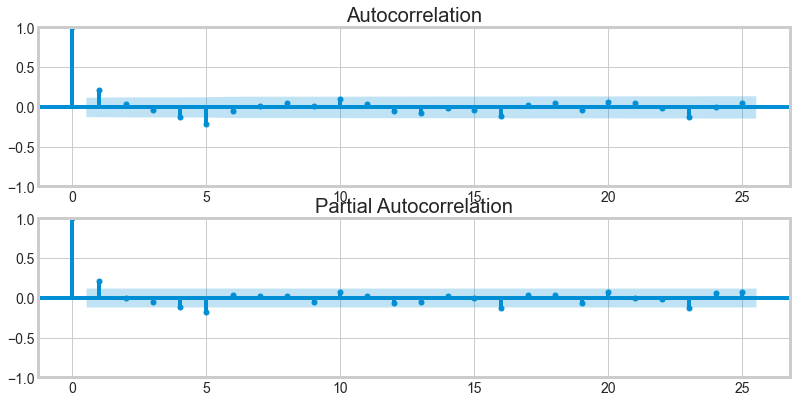

''

In [1526]:
def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])


get_acf_pacf_plots(NASDAQ_data["Adj Close"].resample("W").mean().diff().dropna())
plt.show()
;

### from the ACF and PACF, we see that the P will be 1, and Q also would be 1 


### https://online.stat.psu.edu/stat501/book/export/html/995#:~:text=The%20coefficient%20of%20correlation%20between%20two%20values%20in,gap%20being%20considered%20and%20is%20called%20the%20lag

### https://stats.stackexchange.com/questions/493807/how-to-calculate-the-acf-and-pacf-for-time-series



In [1527]:
#In order see to incorporate spotify valence values, we make use of cross-correlation function
import statsmodels.api as sm
from statsmodels.tsa.innovations import arma_innovations
res = sm.tsa.arima.ARIMA(NASDAQ_data["valence"].resample("W").mean(), order=(5, 0, 0), trend='n').fit()



<AxesSubplot:xlabel='Date'>

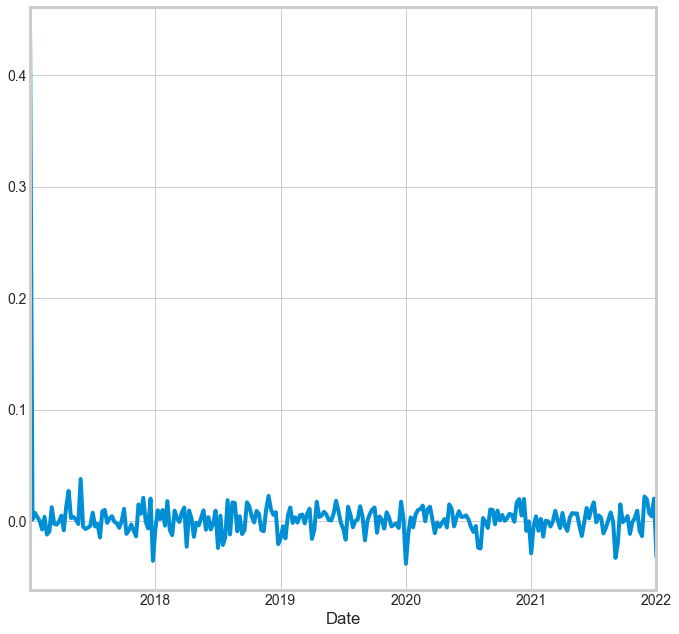

In [1528]:
res.resid.plot()

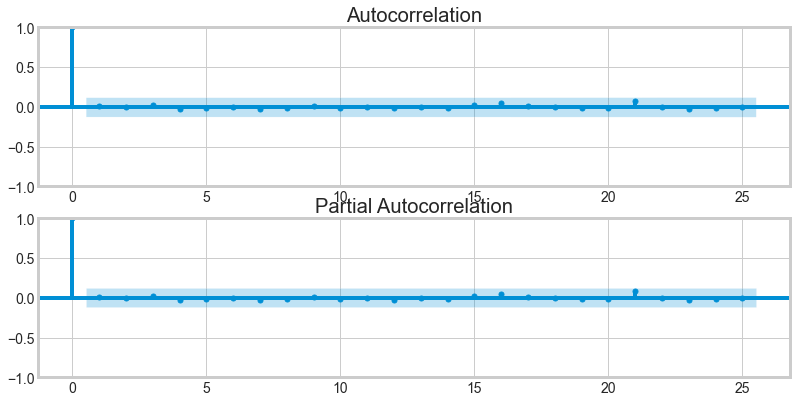

In [1529]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])


get_acf_pacf_plots(res.resid)
plt.show()

In [1530]:
res1 = sm.tsa.arima.ARIMA(NASDAQ_data["Adj Close"].resample("W").mean(), order=(5, 0, 0), trend='n').fit()

<AxesSubplot:xlabel='Date'>

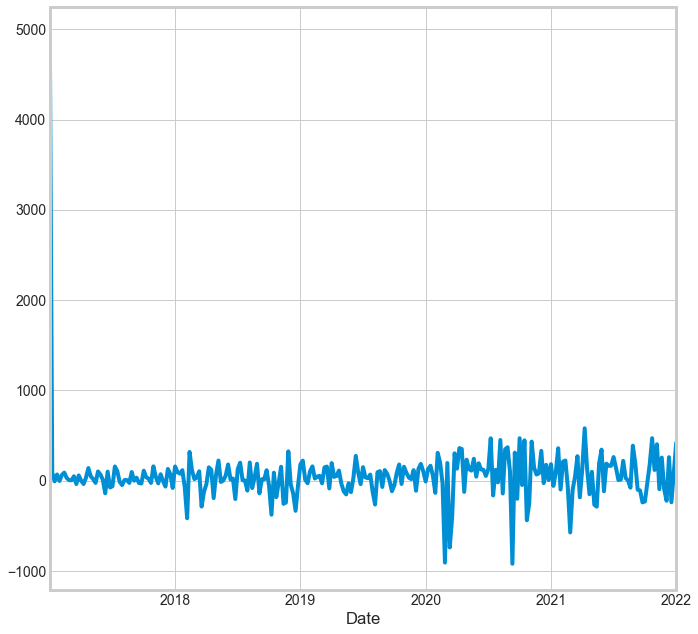

In [1531]:
res1.resid.plot()

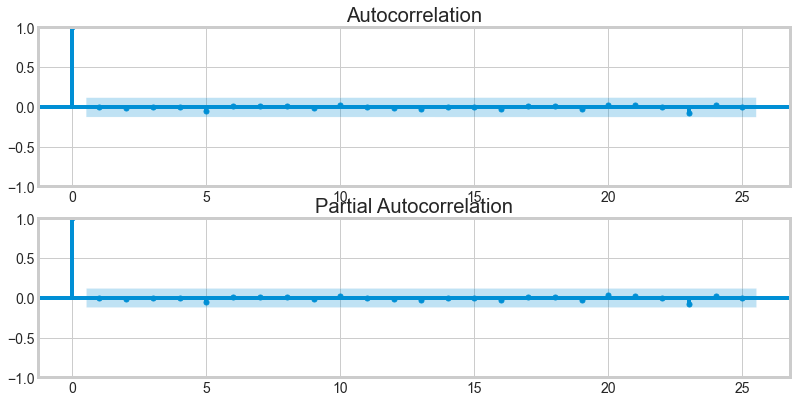

In [1532]:
def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])


get_acf_pacf_plots(res1.resid)
plt.show()

In [1533]:
import statsmodels.api as sm
cross_corr = sm.tsa.stattools.ccf(list(res1.resid), list(res.resid), adjusted=False)
dicti = {}
for i in range(0,20):
    dicti[i+1] = cross_corr[i]

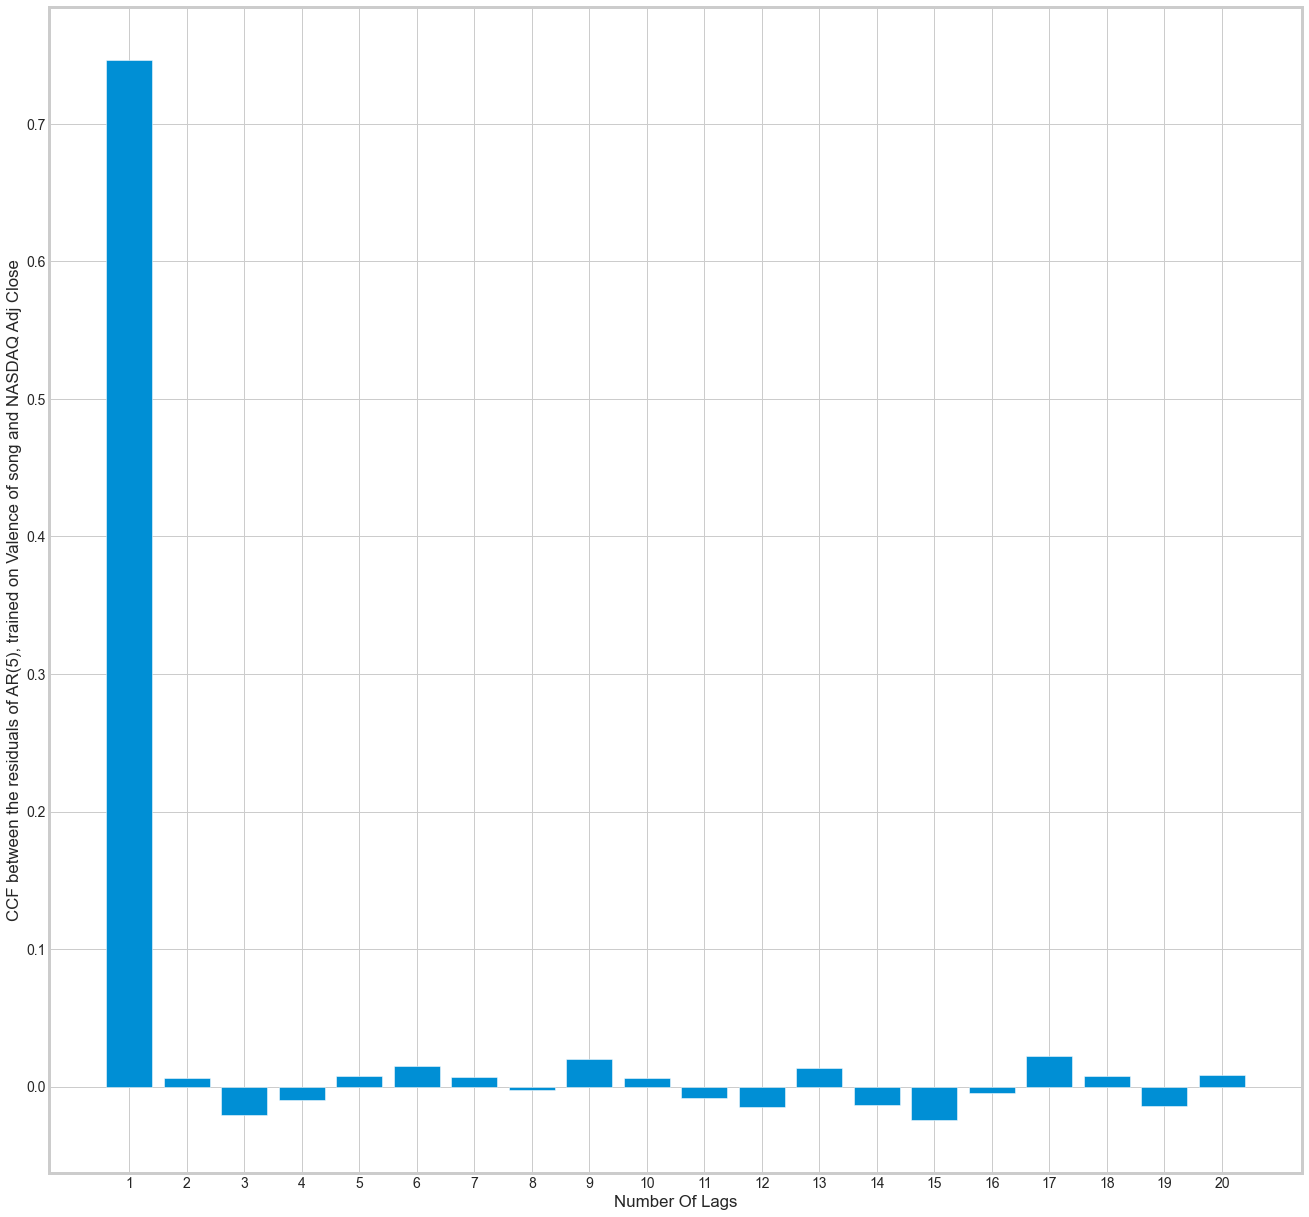

In [1534]:
plt.figure(figsize=(20,20))
names = list(dicti.keys())
values = list(dicti.values())
plt.bar(range(len(dicti)), values, tick_label=names)
plt.ylabel("CCF between the residuals of AR(5), trained on Valence of song and NASDAQ Adj Close")
plt.xlabel("Number Of Lags")
plt.show()

### Applying forecasting with spotify indicator as exogeneous variable, after shifting it by 1

### Lets split the data into train and test before building a forecast

In [1535]:
NASDAQ_data[["Adj Close","valence"]].resample("W").mean().shape

(261, 2)

In [1536]:
train  = NASDAQ_data[["Adj Close","valence"]].resample("W").mean()[0:209]
test = NASDAQ_data[["Adj Close","valence"]].resample("W").mean()[210:]


### Lets forecast, using ARIMA(1,1,1) and also using auto-arima to check if the used ARIMA 1,1,1 is the right value

In [1537]:
SAR = SARIMAX(train["Adj Close"][1:],order=(1,1,1),exog =np.array(train["valence"].shift(+1).dropna()).reshape(208,1))
model_111 = SAR.fit()
#summary of the model can also be seen 
model_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  208
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1379.712
Date:                Wed, 21 Sep 2022   AIC                           2767.423
Time:                        23:47:45   BIC                           2780.754
Sample:                    01-15-2017   HQIC                          2772.814
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -569.5275   1469.205     -0.388      0.698   -3449.116    2310.061
ar.L1          0.3970      0.200      1.984      0.047       0.005       0.789
ma.L1         -0.2152      0.228     -0.943      0.346      -0.663       0.232
sigma2      3.604e+04   2094.910     17.204      0.000    3.19e+04    4.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               426.39
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               6.40   Skew:                            -1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###  in order to tune the model for different values of P,D and Q we will run auto-arima which will find the best fit based on AIC criterion

In [1538]:
#from pyramid.arima import auto_arima
AA = pm.auto_arima(train["Adj Close"][1:],np.array(train["valence"].shift(+1).dropna()).reshape(208,1), suppress_warnings=True,
                   stepwise=True, seasonal=True,trace=True, start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=3,
                      )
                 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2765.336, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2762.228, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2762.690, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2771.445, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2764.044, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2764.196, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2764.287, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2765.938, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.763 seconds


In [1539]:
AA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  208
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1377.114
Date:                Wed, 21 Sep 2022   AIC                           2762.228
Time:                        23:47:46   BIC                           2775.559
Sample:                    01-15-2017   HQIC                          2767.619
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     32.0720     15.368      2.087      0.037       1.951      62.193
x1          -569.5368   1591.394     -0.358      0.720   -3688.611    2549.537
ar.L1          0.1555      0.053      2.919      0.004       0.051       0.260
sigma2      3.513e+04   2132.125     16.478      0.000     3.1e+04    3.93e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               424.91
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               6.59   Skew:                            -1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1540]:
SAR = SARIMAX(train["Adj Close"][1:],order=(2,1,0),exog =np.array(train["valence"].shift(+1).dropna()).reshape(208,1))
model_210 = SAR.fit()

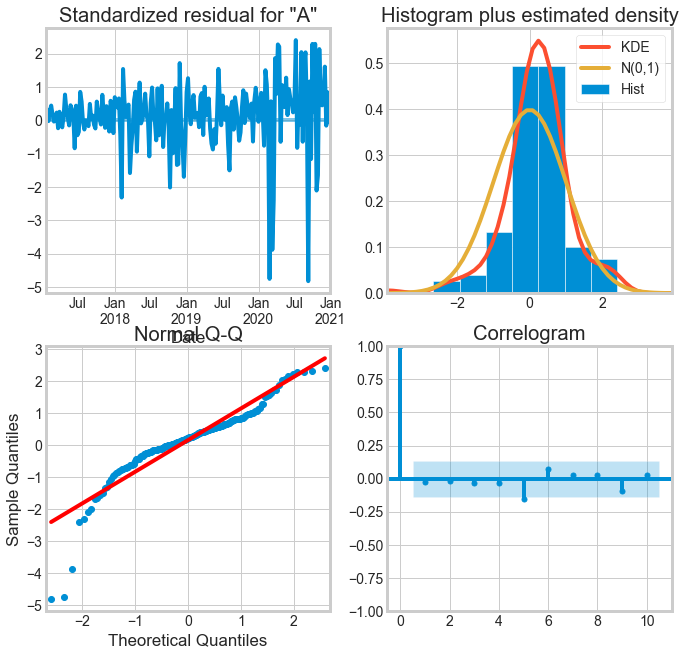

In [1541]:
model_210.plot_diagnostics(figsize=(10,10));

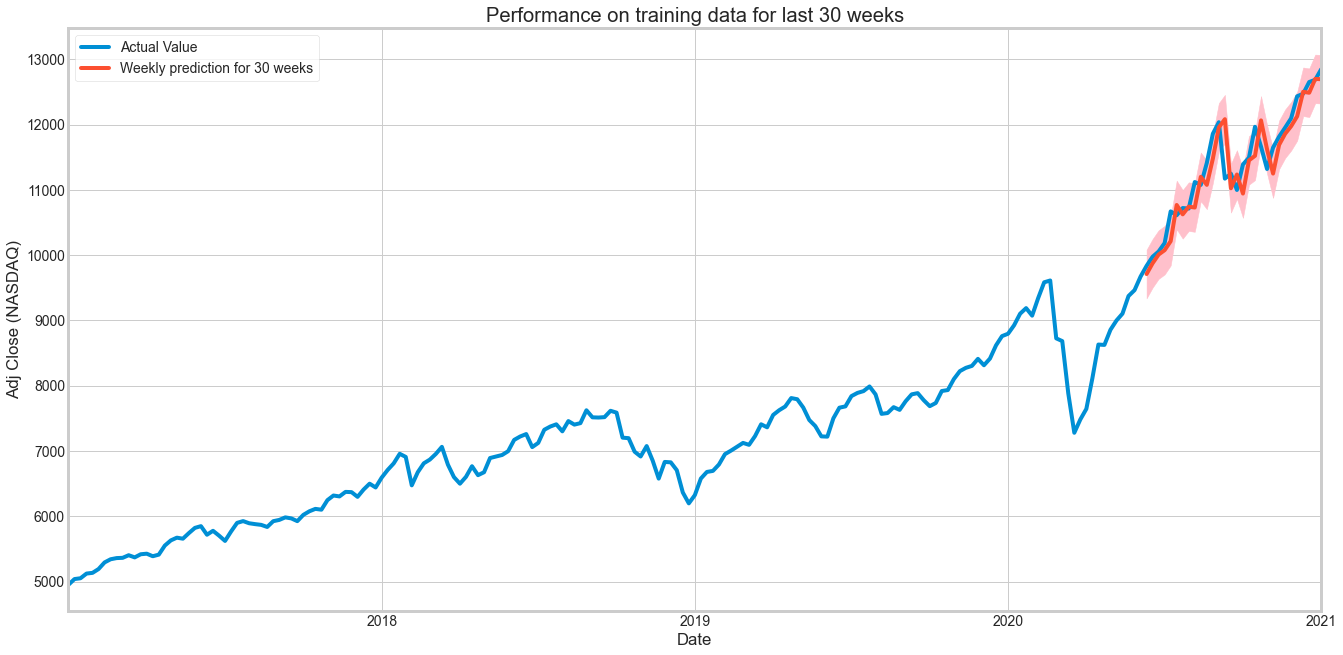

In [1542]:
#Lets see how the model performs on the training data
train["Adj Close"].plot(figsize=(20,10),label="Actual Value")
model_111.get_prediction(start=-30).predicted_mean.plot(label="Weekly prediction for 30 weeks")
conf_int_111 = model_111.get_prediction(start=-30).conf_int()
plt.fill_between(conf_int_111.index,conf_int_111["lower Adj Close"],conf_int_111["upper Adj Close"],color="pink")
plt.title("Performance on training data for last 30 weeks")
plt.ylabel("Adj Close (NASDAQ)")
plt.legend()

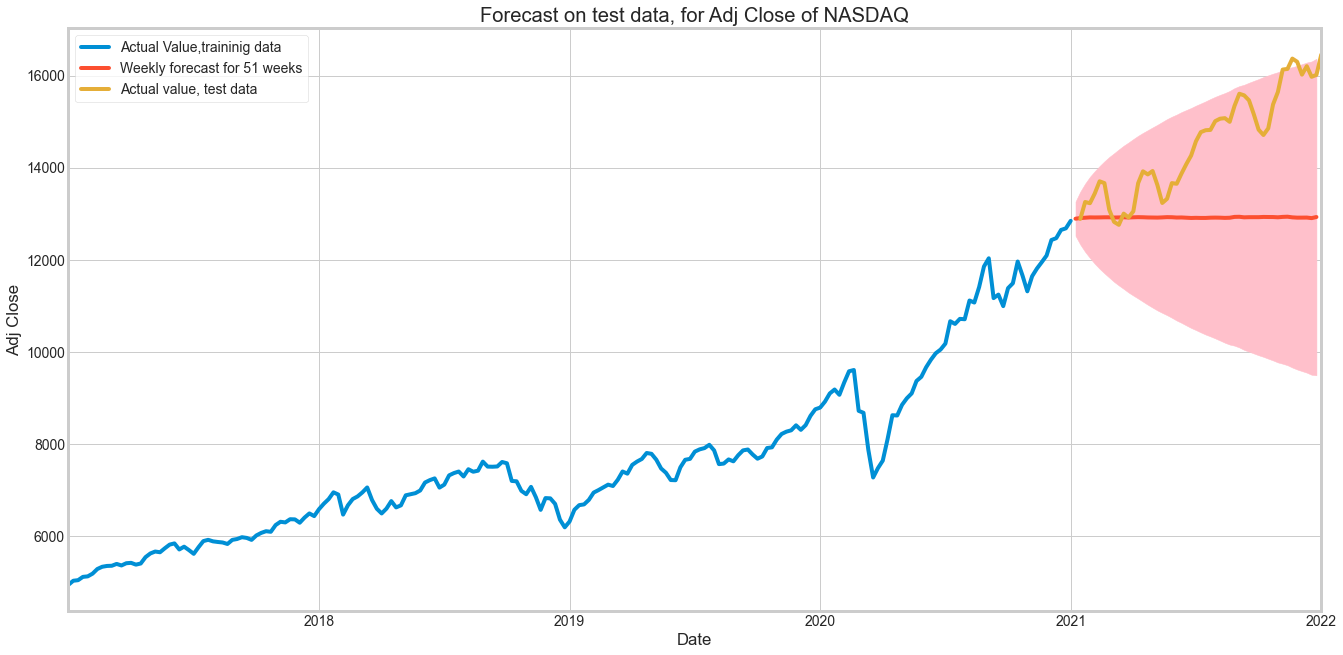

In [1543]:
#Forecasting for the next 30 weeks
train["Adj Close"].plot(figsize=(20,10),label="Actual Value,traininig data")
model_111.get_forecast(steps=51,exog =test["valence"]).predicted_mean.plot(label="Weekly forecast for 51 weeks")
test["Adj Close"].plot(label="Actual value, test data")
conf_int_forecast = model_111.get_forecast(steps=51,exog =test["valence"]).conf_int()
plt.fill_between(conf_int_forecast.index,conf_int_forecast["lower Adj Close"],conf_int_forecast["upper Adj Close"],color="pink")
plt.title("Forecast on test data, for Adj Close of NASDAQ")
plt.ylabel("Adj Close")
plt.legend()

In [1544]:
from sklearn.metrics import mean_absolute_error as mae
mae(test["Adj Close"], model_111.get_forecast(steps=51,exog =test["valence"]).predicted_mean)


1603.7394052397533

In [1545]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(test["Adj Close"], model_111.get_forecast(steps=51,exog =test["valence"]).predicted_mean)

10.525077912440915

### Performing similar analytics for Sao Paulo sataset

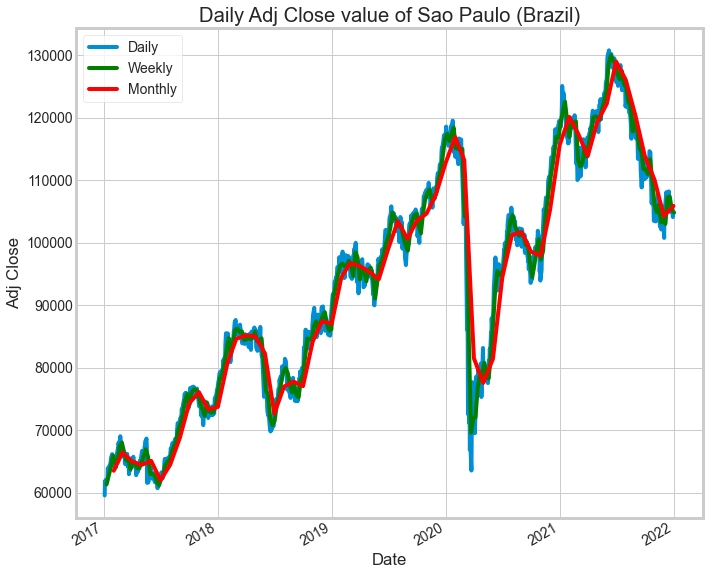

In [1546]:
plt.figure(figsize=(10,10))
BVSP_data["Adj Close"].plot(label="Daily")
BVSP_data["Adj Close"].resample("W").mean().plot(label="Weekly",color="green")
BVSP_data["Adj Close"].resample("M").mean().plot(label="Monthly",color="red")
plt.title("Daily Adj Close value of Sao Paulo (Brazil)")
plt.ylabel("Adj Close")
plt.legend()

In [1547]:
y = BVSP_data["Adj Close"].resample("W").mean()


''

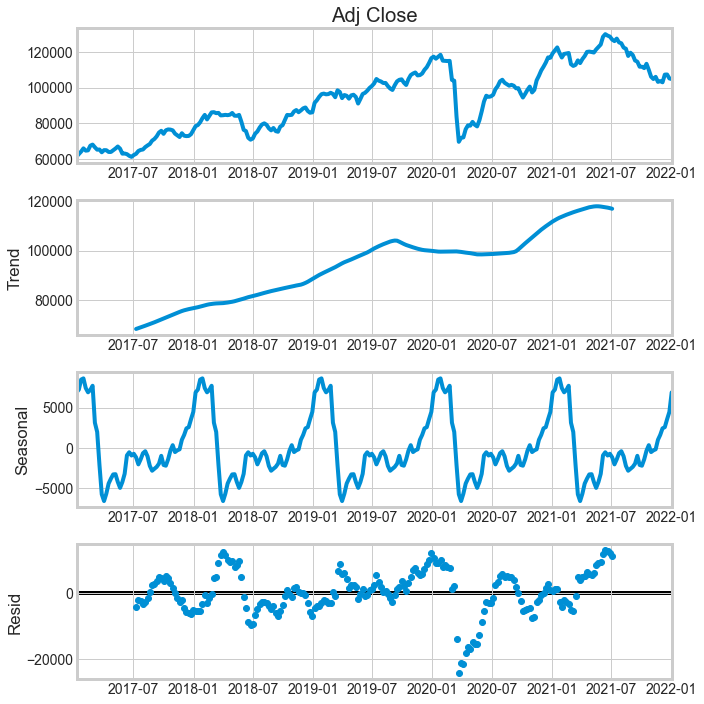

In [1548]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y.dropna(), model="additive")
plt.rcParams.update({'figure.figsize': (10,10)})
decomposition.plot()
;

In [1549]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [1550]:
adf_test(BVSP_data["Adj Close"].resample("W").mean())

Results of Dickey-Fuller Test:
Test Statistic                  -1.904513
p-value                          0.329941
#Lags Used                       1.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [1551]:
NASDAQ_data["Adj Close"].resample("W").mean().diff().dropna()

Date
2017-01-15     87.712500
2017-01-22     12.475000
2017-01-29     71.675000
2017-02-05     11.050000
2017-02-12     58.600000
                 ...    
2021-12-05   -279.650000
2021-12-12    182.850000
2021-12-19   -229.785937
2021-12-26     40.985937
2022-01-02    440.400000
Freq: W-SUN, Name: Adj Close, Length: 260, dtype: float64

In [1552]:
#first differencing,gives the following result
Z = BVSP_data["Adj Close"].resample("W").mean().diff().dropna()

''

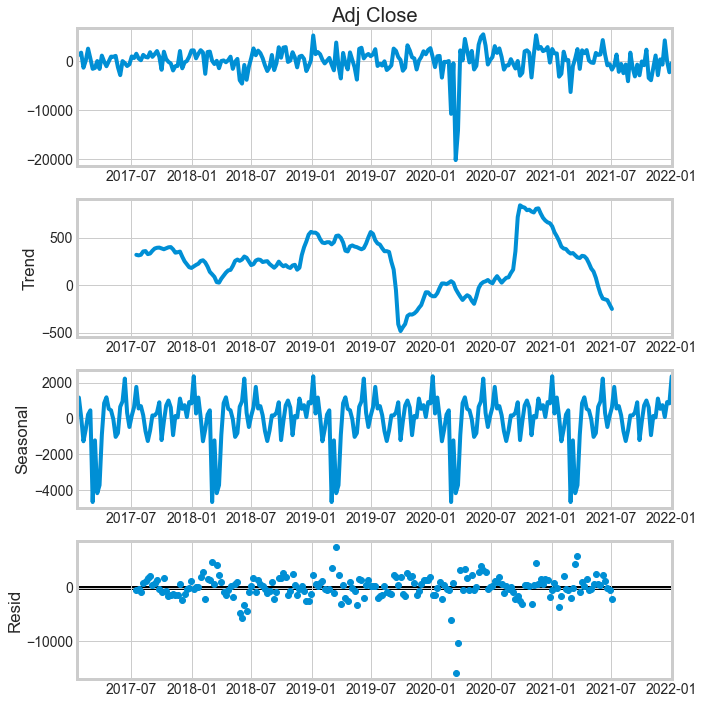

In [1553]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(Z, model="additive")
decomposition.plot()
;

In [1554]:
#Lets see the output of ADF after first differencing, 
adf_test(BVSP_data["Adj Close"].resample("W").mean().diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.148452e+01
p-value                        4.902388e-21
#Lags Used                     0.000000e+00
Number of Observations Used    2.590000e+02
Critical Value (1%)           -3.455853e+00
Critical Value (5%)           -2.872765e+00
Critical Value (10%)          -2.572752e+00
dtype: float64


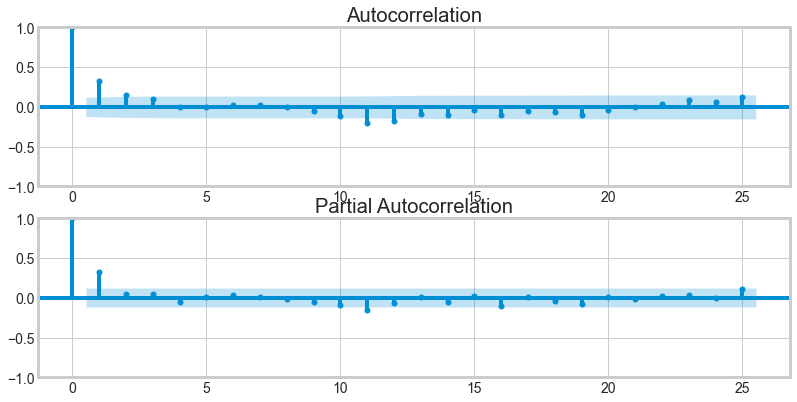

''

In [1555]:
def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])


get_acf_pacf_plots(BVSP_data["Adj Close"].resample("W").mean().diff().dropna())
plt.show()
;

In [1556]:
#In order see to incorporate spotify valence values, we make use of cross-correlation function
import statsmodels.api as sm
from statsmodels.tsa.innovations import arma_innovations
res = sm.tsa.arima.ARIMA(BVSP_data["valence"].resample("W").mean(), order=(5, 0, 0), trend='n').fit()


<AxesSubplot:xlabel='Date'>

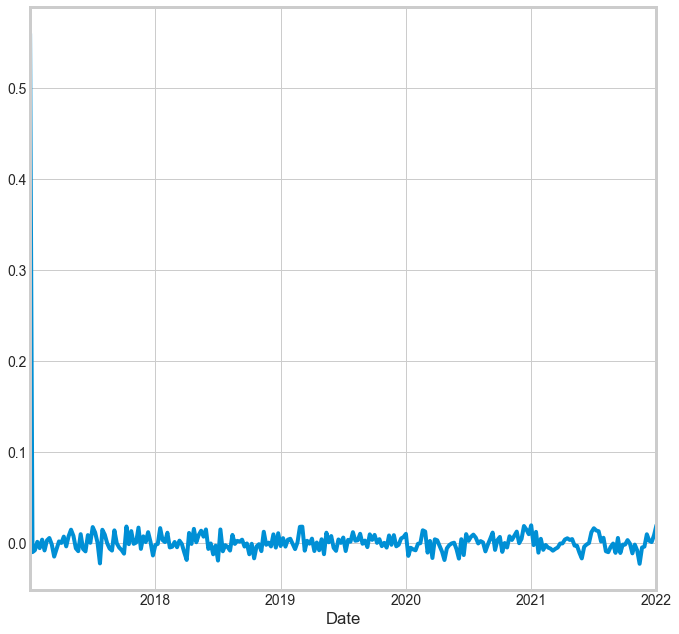

In [1557]:
res.resid.plot()

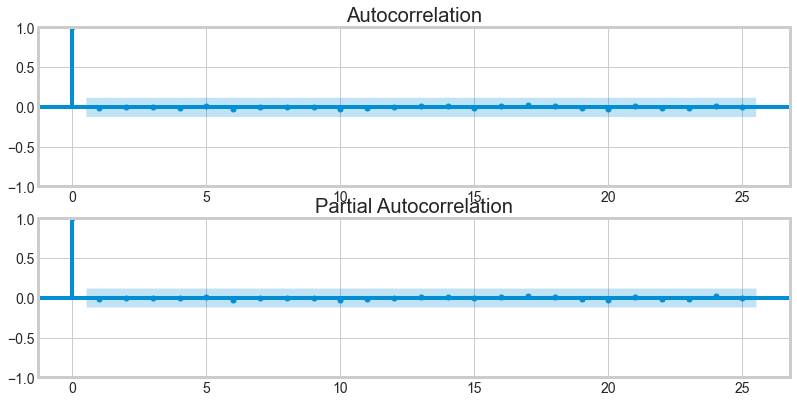

In [1558]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])


get_acf_pacf_plots(res.resid)
plt.show()

In [1559]:
res1 = sm.tsa.arima.ARIMA(BVSP_data["Adj Close"].resample("W").mean(), order=(5, 0, 0), trend='n').fit()

<AxesSubplot:xlabel='Date'>

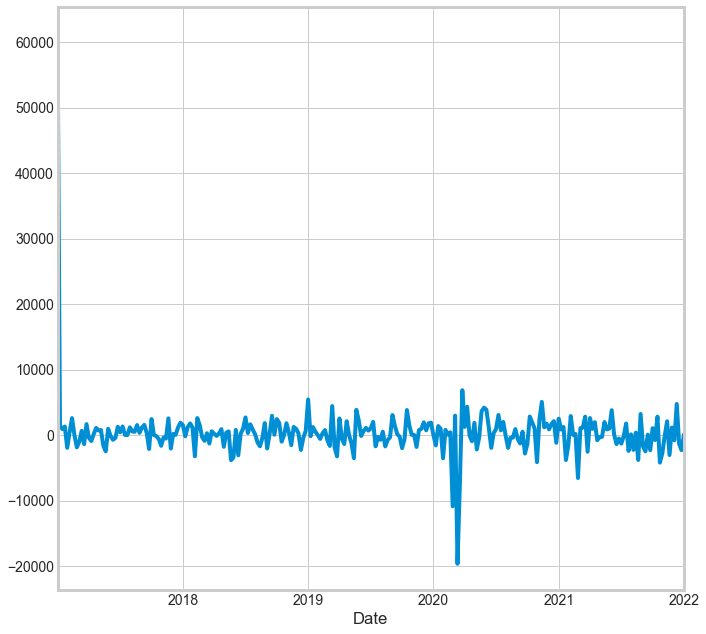

In [1560]:
res1.resid.plot()

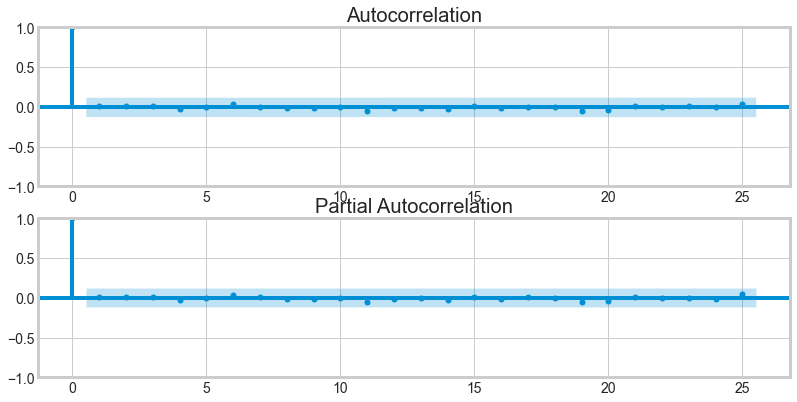

In [1561]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])


get_acf_pacf_plots(res1.resid)
plt.show()

In [1562]:
import statsmodels.api as sm
cross_corr = sm.tsa.stattools.ccf(list(res1.resid), list(res.resid), adjusted=False)
dicti = {}
for i in range(0,20):
    dicti[i+1] = cross_corr[i]

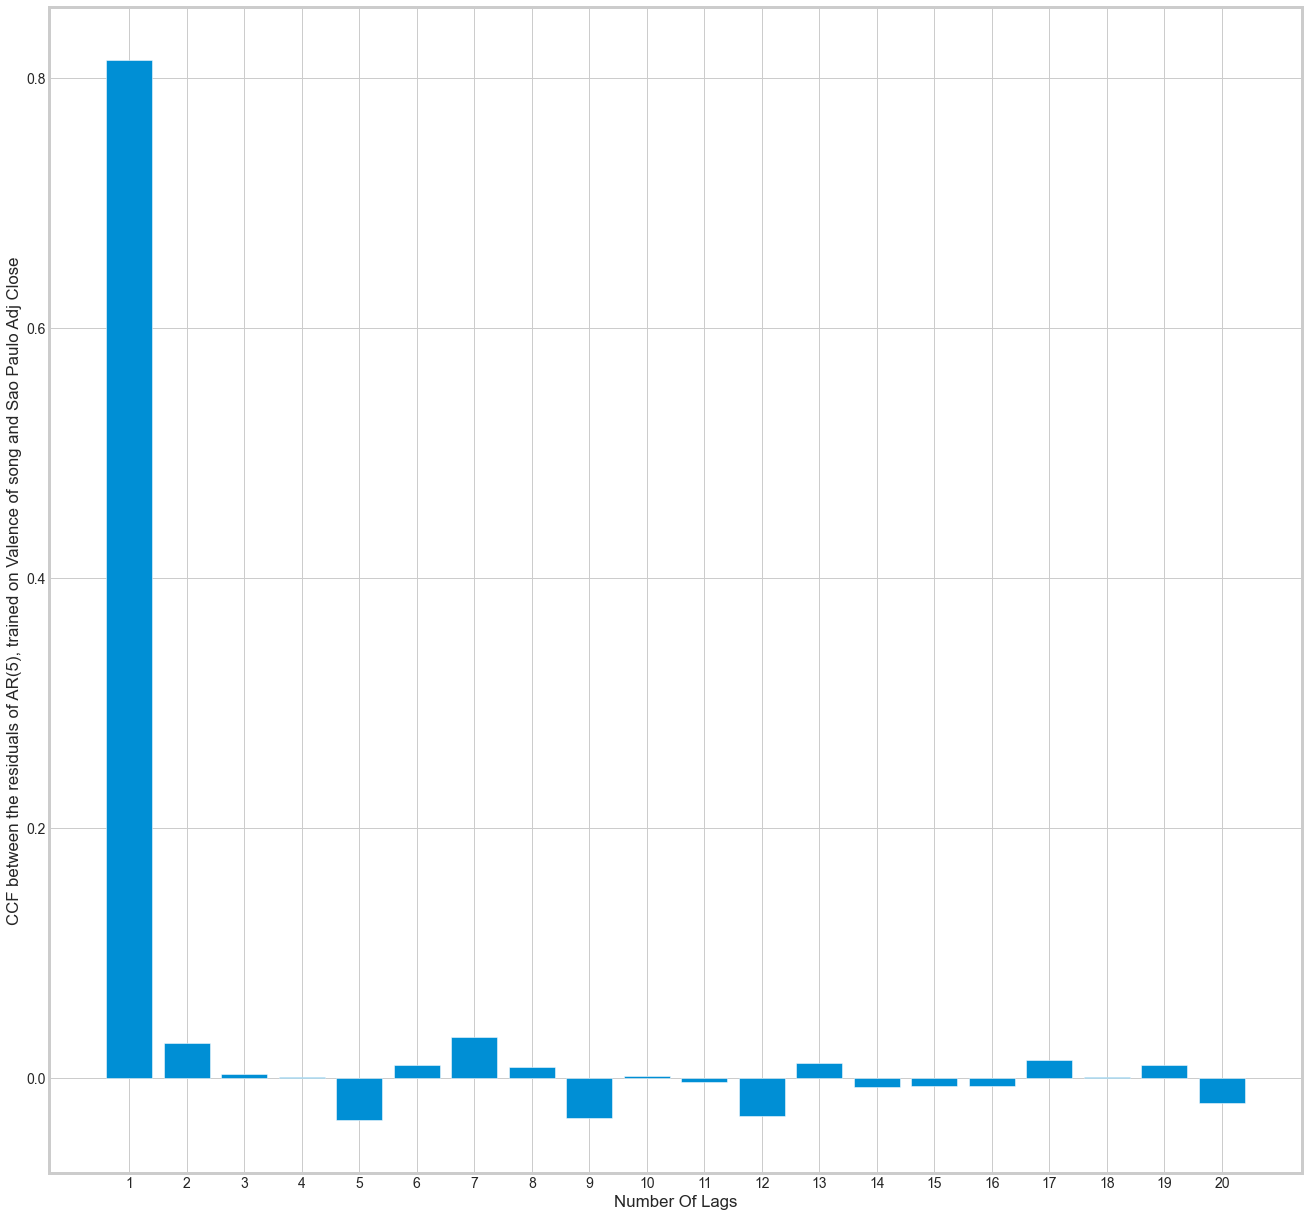

In [1563]:
plt.figure(figsize=(20,20))
names = list(dicti.keys())
values = list(dicti.values())
plt.bar(range(len(dicti)), values, tick_label=names)
plt.ylabel("CCF between the residuals of AR(5), trained on Valence of song and Sao Paulo Adj Close")
plt.xlabel("Number Of Lags")
plt.show()

In [1564]:
BVSP_data[["Adj Close","valence"]].resample("W").mean().shape

(261, 2)

In [1565]:
train  = BVSP_data[["Adj Close","valence"]].resample("W").mean()[0:209]
test = BVSP_data[["Adj Close","valence"]].resample("W").mean()[210:]


In [1566]:
SAR = SARIMAX(train["Adj Close"][1:],order=(1,1,2),exog =np.array(train["valence"].shift(+1).dropna()).reshape(208,1))
model_112 = SAR.fit()
#summary of the model can also be seen 
model_112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  208
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1911.920
Date:                Wed, 21 Sep 2022   AIC                           3833.840
Time:                        23:48:01   BIC                           3850.503
Sample:                    01-15-2017   HQIC                          3840.578
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.084e+04   1.51e+04      2.045      0.041    1286.024    6.04e+04
ar.L1          0.3242      0.482      0.672      0.502      -0.621       1.270
ma.L1         -0.1473      0.503     -0.293      0.770      -1.134       0.839
ma.L2          0.0299      0.082      0.367      0.714      -0.130       0.190
sigma2      5.971e+06   2.75e+05     21.736      0.000    5.43e+06    6.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.36   Jarque-Bera (JB):              3296.56
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               6.56   Skew:                            -2.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1567]:
#from pyramid.arima import auto_arima
AA = pm.auto_arima(train["Adj Close"][1:],np.array(train["valence"].shift(+1).dropna()).reshape(208,1), suppress_warnings=True,
                   stepwise=True, seasonal=True,trace=True, start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=3,
                      )
                 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4523.477, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3900.684, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4280.053, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5424.878, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3881.074, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3882.861, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3882.596, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3881.329, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3880.700, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3876.656, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3877.779, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3878.645, Time=0.22 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3878.666, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3879.122, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept

In [1568]:
AA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  208
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -1930.249
Date:                Wed, 21 Sep 2022   AIC                           3874.498
Time:                        23:48:04   BIC                           3897.861
Sample:                    01-15-2017   HQIC                          3883.945
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.472e+05   7649.623     19.247      0.000    1.32e+05    1.62e+05
ar.L1          0.7373      0.219      3.372      0.001       0.309       1.166
ar.L2          0.3585      0.309      1.159      0.247      -0.248       0.965
ar.L3          0.0506      0.145      0.350      0.726      -0.233       0.334
ar.L4         -0.1961      0.075     -2.608      0.009      -0.343      -0.049
ma.L1          0.5694      0.224      2.537      0.011       0.130       1.009
sigma2      6.699e+06     44.822   1.49e+05      0.000     6.7e+06     6.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1192.74
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.32   Skew:                            -2.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.57e+20. Standard errors may be unstable.
"""

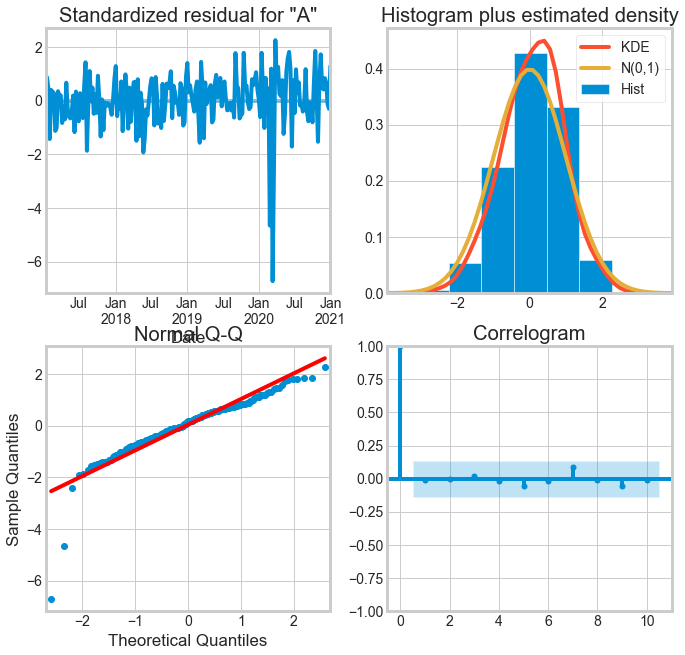

In [1569]:
SAR = SARIMAX(train["Adj Close"][1:],order=(4,0,1),exog =np.array(train["valence"].shift(+1).dropna()).reshape(208,1))
model_401 = SAR.fit()
#summary of the model can also be seen 
model_401.plot_diagnostics(figsize=(10,10));

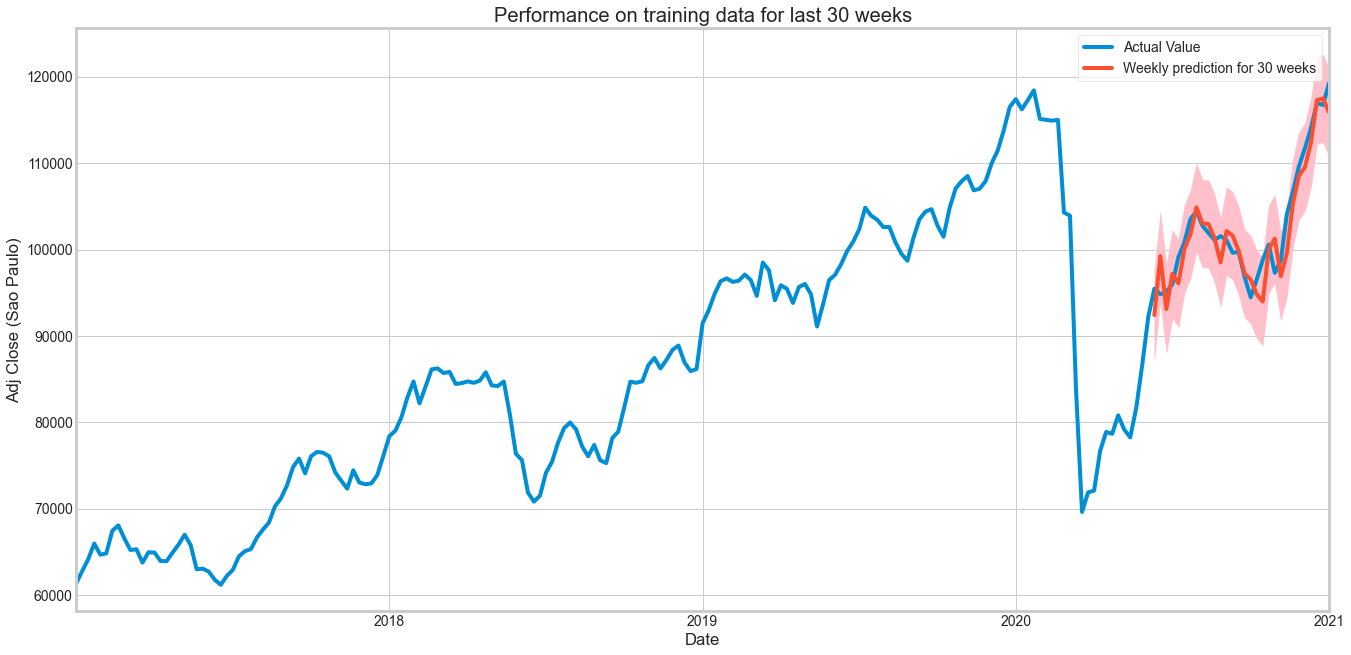

In [1570]:
#Lets see how the model performs on the training data
train["Adj Close"].plot(figsize=(20,10),label="Actual Value")
model_401.get_prediction(start=-30).predicted_mean.plot(label="Weekly prediction for 30 weeks")
conf_int_401 = model_401.get_prediction(start=-30).conf_int()
plt.fill_between(conf_int_401.index,conf_int_401["lower Adj Close"],conf_int_401["upper Adj Close"],color="pink")
plt.title("Performance on training data for last 30 weeks")
plt.ylabel("Adj Close (Sao Paulo)")
plt.legend()

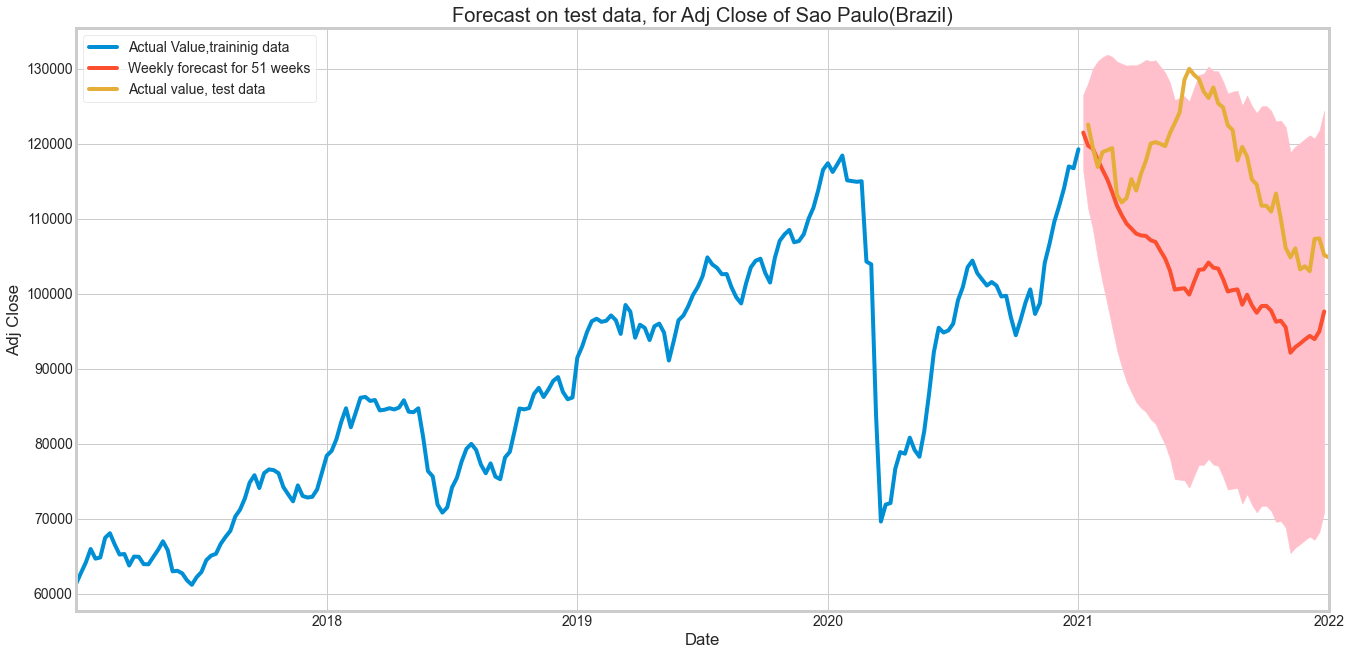

In [1571]:
#Forecasting for the next 30 weeks
train["Adj Close"].plot(figsize=(20,10),label="Actual Value,traininig data")
model_401.get_forecast(steps=51,exog =test["valence"]).predicted_mean.plot(label="Weekly forecast for 51 weeks")
test["Adj Close"].plot(label="Actual value, test data")
conf_int_forecast = model_401.get_forecast(steps=51,exog =test["valence"]).conf_int()
plt.fill_between(conf_int_forecast.index,conf_int_forecast["lower Adj Close"],conf_int_forecast["upper Adj Close"],color="pink")
plt.title("Forecast on test data, for Adj Close of Sao Paulo(Brazil)")
plt.ylabel("Adj Close")
plt.legend()

In [1572]:
from sklearn.metrics import mean_absolute_error as mae
mae(test["Adj Close"], model_401.get_forecast(steps=51,exog =test["valence"]).predicted_mean)


13507.608964601184

In [1573]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(test["Adj Close"], model_401.get_forecast(steps=51,exog =test["valence"]).predicted_mean)

11.38173392563034

### Performing similar analytics for IPC mexico sataset

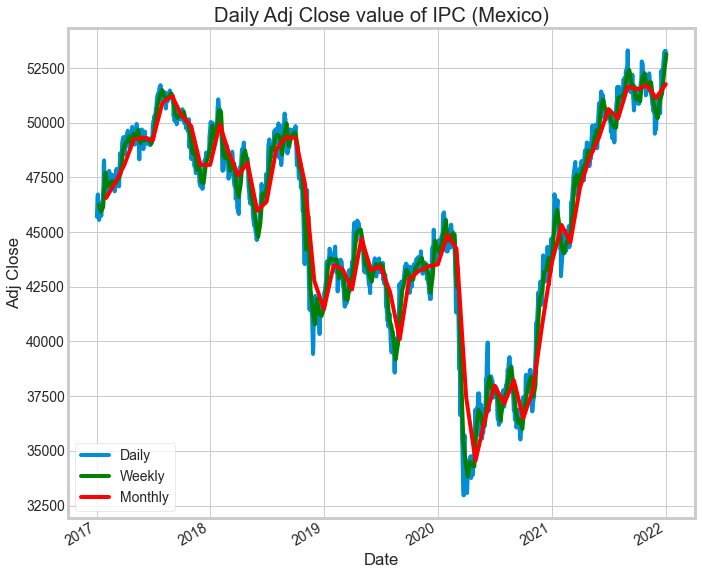

In [1574]:
plt.figure(figsize=(10,10))
IPC_data["Adj Close"].plot(label="Daily")
IPC_data["Adj Close"].resample("W").mean().plot(label="Weekly",color="green")
IPC_data["Adj Close"].resample("M").mean().plot(label="Monthly",color="red")
plt.title("Daily Adj Close value of IPC (Mexico)")
plt.ylabel("Adj Close")
plt.legend()

In [1575]:
y = IPC_data["Adj Close"].resample("W").mean()

''

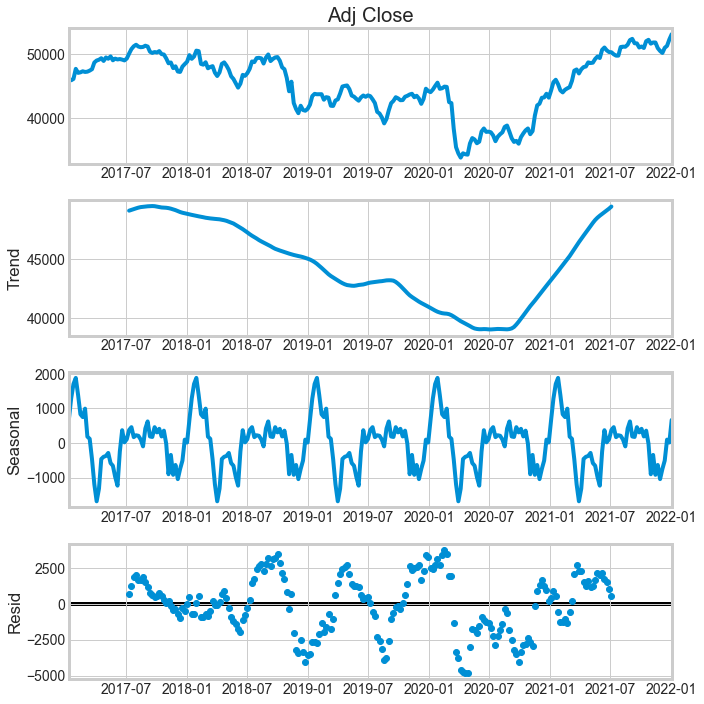

In [1576]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y.dropna(), model="additive")
plt.rcParams.update({'figure.figsize': (10,10)})
decomposition.plot()
;

In [1577]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [1578]:
adf_test(BVSP_data["Adj Close"].resample("W").mean())

Results of Dickey-Fuller Test:
Test Statistic                  -1.904513
p-value                          0.329941
#Lags Used                       1.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [1579]:
NASDAQ_data["Adj Close"].resample("W").mean().diff().dropna()

Date
2017-01-15     87.712500
2017-01-22     12.475000
2017-01-29     71.675000
2017-02-05     11.050000
2017-02-12     58.600000
                 ...    
2021-12-05   -279.650000
2021-12-12    182.850000
2021-12-19   -229.785937
2021-12-26     40.985937
2022-01-02    440.400000
Freq: W-SUN, Name: Adj Close, Length: 260, dtype: float64

In [1580]:
#first differencing,gives the following result
Z = BVSP_data["Adj Close"].resample("W").mean().diff().dropna()

''

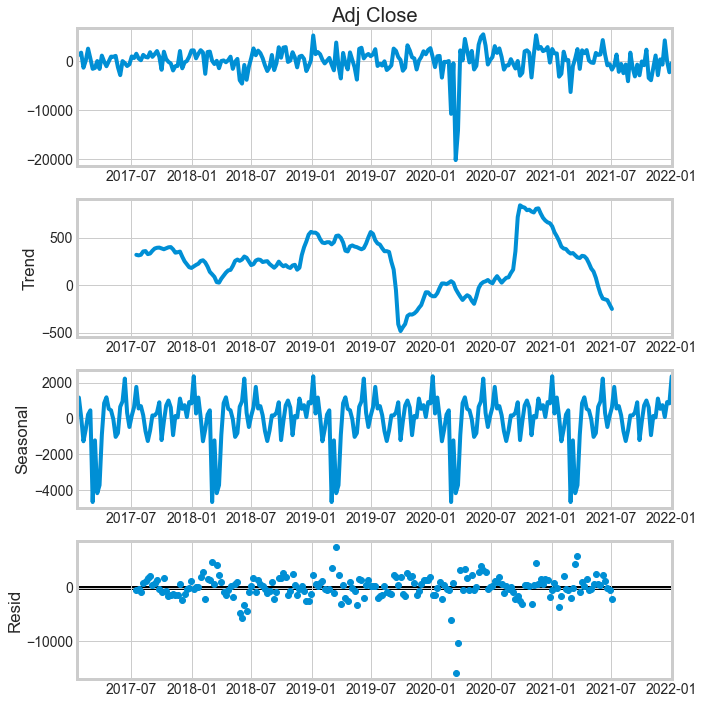

In [1581]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(Z, model="additive")
decomposition.plot()
;

In [1582]:
#Lets see the output of ADF after first differencing, 
adf_test(BVSP_data["Adj Close"].resample("W").mean().diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.148452e+01
p-value                        4.902388e-21
#Lags Used                     0.000000e+00
Number of Observations Used    2.590000e+02
Critical Value (1%)           -3.455853e+00
Critical Value (5%)           -2.872765e+00
Critical Value (10%)          -2.572752e+00
dtype: float64


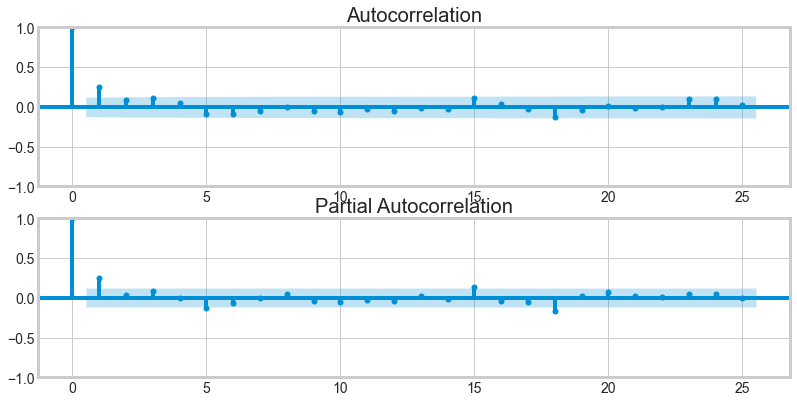

''

In [1583]:
def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])


get_acf_pacf_plots(IPC_data["Adj Close"].resample("W").mean().diff().dropna())
plt.show()
;

In [1584]:
#In order see to incorporate spotify valence values, we make use of cross-correlation function
import statsmodels.api as sm
from statsmodels.tsa.innovations import arma_innovations
res = sm.tsa.arima.ARIMA(IPC_data["valence"].resample("W").mean(), order=(5, 0, 0), trend='n').fit()


<AxesSubplot:xlabel='Date'>

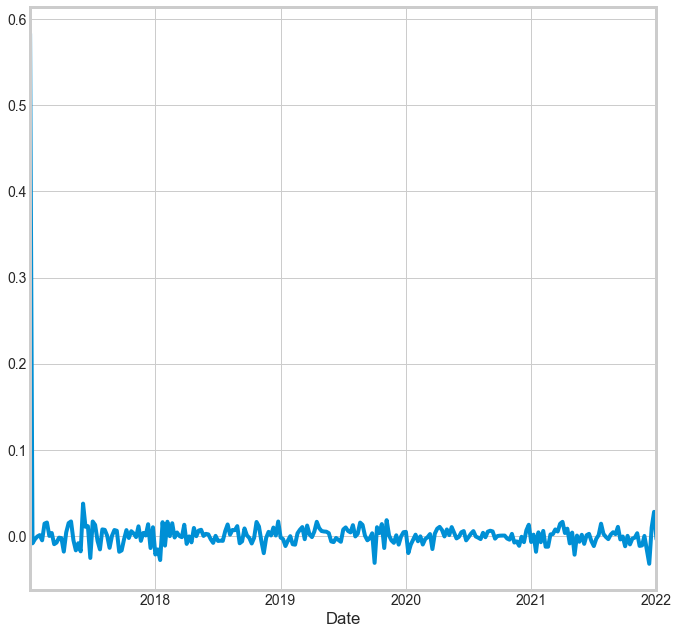

In [1585]:
res.resid.plot()

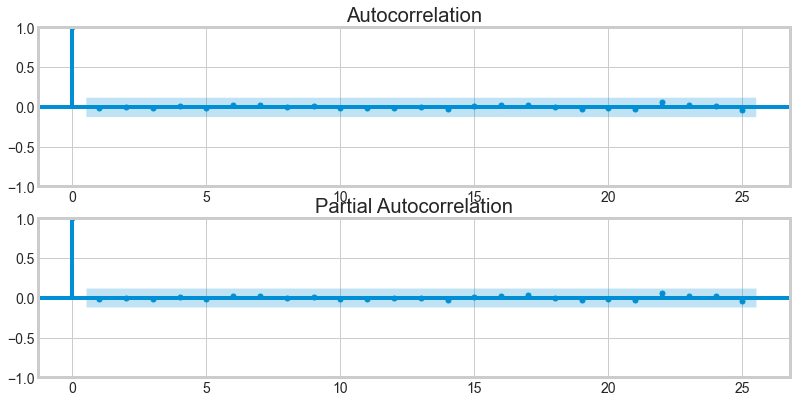

In [1586]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])


get_acf_pacf_plots(res.resid)
plt.show()

In [1587]:
#In order see to incorporate spotify valence values, we make use of cross-correlation function
import statsmodels.api as sm
from statsmodels.tsa.innovations import arma_innovations
res1 = sm.tsa.arima.ARIMA(IPC_data["Adj Close"].resample("W").mean(), order=(5, 0, 0), trend='n').fit()


<AxesSubplot:xlabel='Date'>

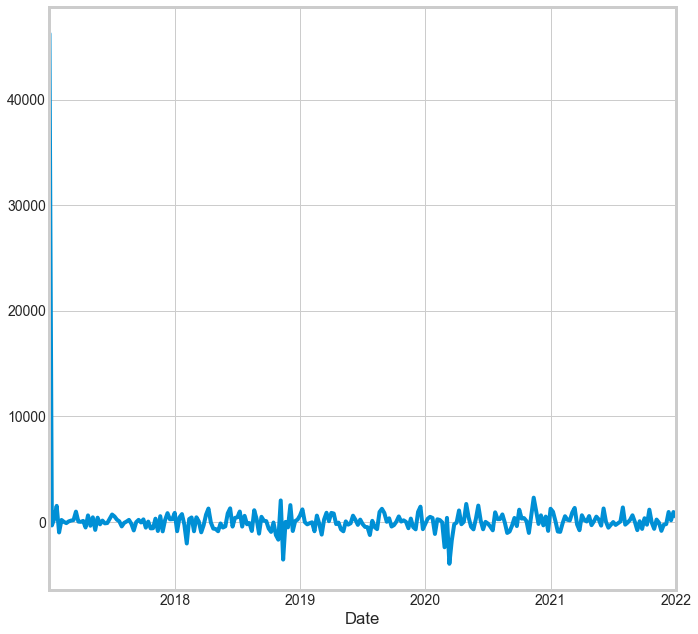

In [1588]:
res1.resid.plot()

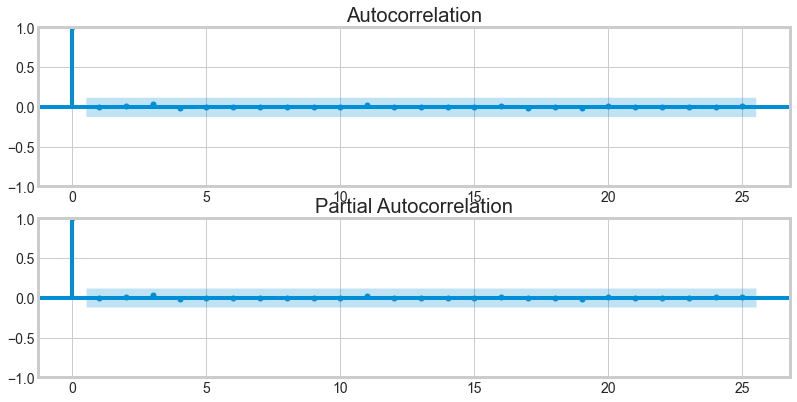

In [1589]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])


get_acf_pacf_plots(res1.resid)
plt.show()

In [1590]:
import statsmodels.api as sm
cross_corr = sm.tsa.stattools.ccf(list(res1.resid), list(res.resid), adjusted=False)
dicti = {}
for i in range(0,20):
    dicti[i+1] = cross_corr[i]

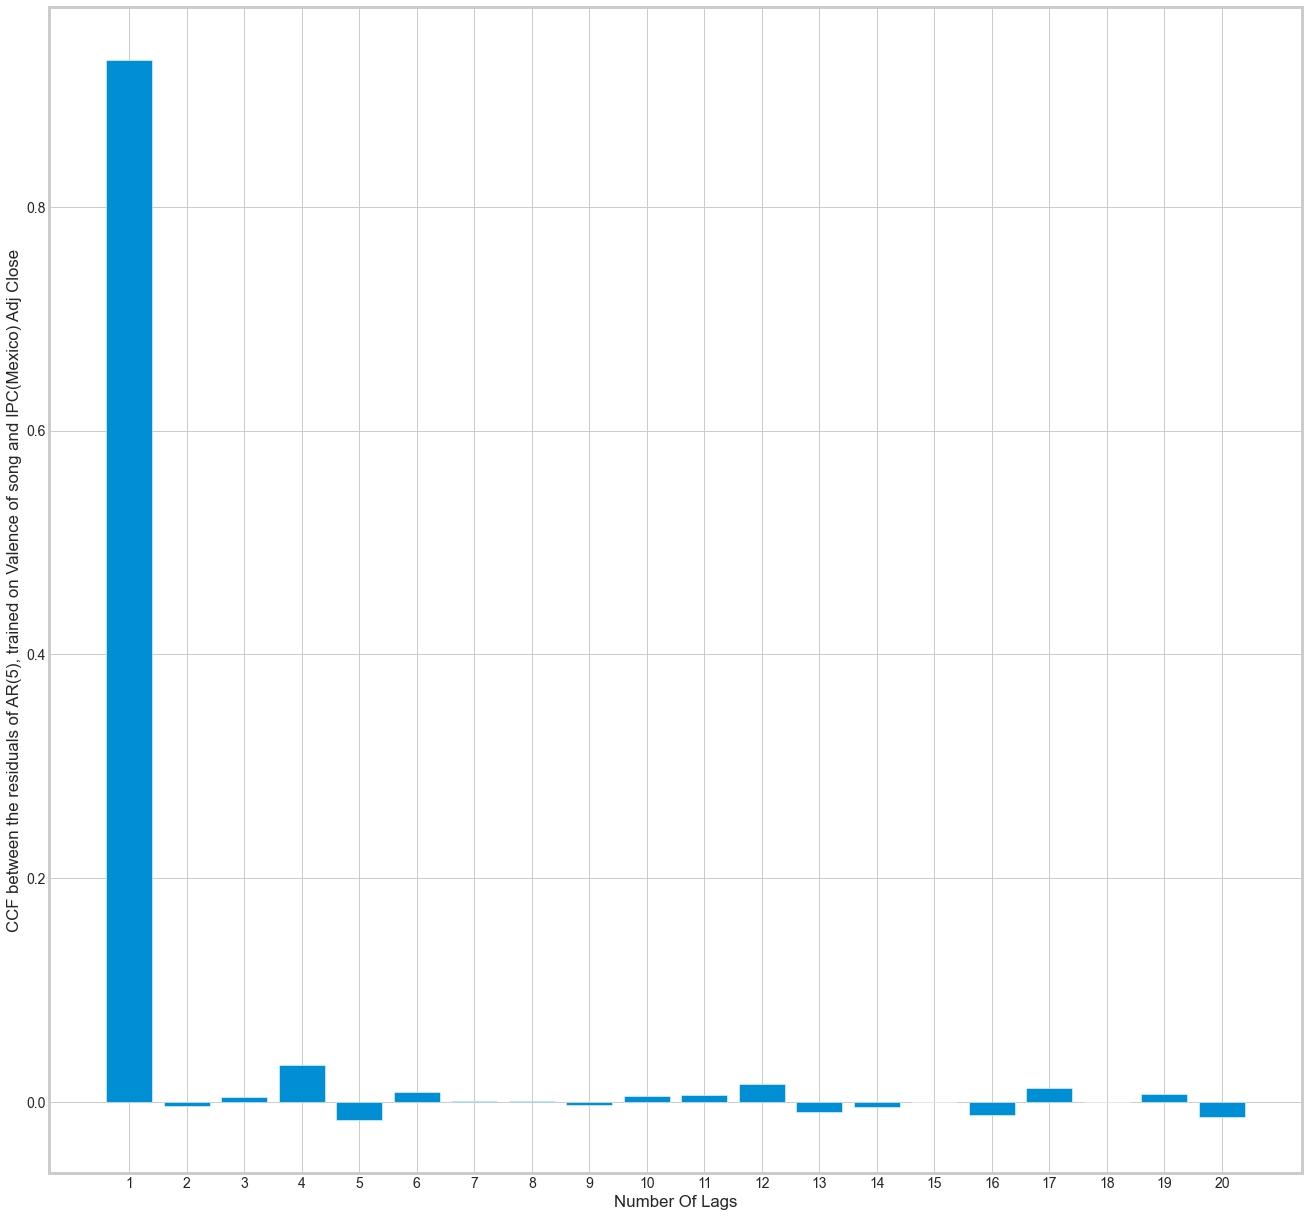

In [1591]:
plt.figure(figsize=(20,20))
names = list(dicti.keys())
values = list(dicti.values())
plt.bar(range(len(dicti)), values, tick_label=names)
plt.ylabel("CCF between the residuals of AR(5), trained on Valence of song and IPC(Mexico) Adj Close")
plt.xlabel("Number Of Lags")
plt.show()

In [1592]:
IPC_data[["Adj Close","valence"]].resample("W").mean().shape

(261, 2)

In [1593]:
train  = IPC_data[["Adj Close","valence"]].resample("W").mean()[0:209]
test = IPC_data[["Adj Close","valence"]].resample("W").mean()[210:]


In [1594]:
SAR = SARIMAX(train["Adj Close"][1:],order=(1,1,1),exog =np.array(train["valence"].shift(+1).dropna()).reshape(208,1))
model_111 = SAR.fit()
model_111.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  208
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1679.335
Date:                Wed, 21 Sep 2022   AIC                           3366.670
Time:                        23:48:22   BIC                           3380.000
Sample:                    01-15-2017   HQIC                          3372.060
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           117.1649   7967.331      0.015      0.988   -1.55e+04    1.57e+04
ar.L1          0.5510      0.245      2.250      0.024       0.071       1.031
ma.L1         -0.4657      0.258     -1.807      0.071      -0.971       0.040
sigma2      6.277e+05   3.95e+04     15.902      0.000     5.5e+05    7.05e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.88   Jarque-Bera (JB):               145.41
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1595]:
#from pyramid.arima import auto_arima
AA = pm.auto_arima(train["Adj Close"][1:],np.array(train["valence"].shift(+1).dropna()).reshape(208,1), suppress_warnings=True,
                   stepwise=True, seasonal=True,trace=True, start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=3,
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3372.567, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3369.989, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3370.725, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3370.590, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3366.252, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3368.308, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3368.286, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3368.543, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3370.289, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3364.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3368.030, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3366.383, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3366.356, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3366.670, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]          

In [1596]:
AA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  208
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1678.186
Date:                Wed, 21 Sep 2022   AIC                           3364.371
Time:                        23:48:23   BIC                           3377.702
Sample:                    01-15-2017   HQIC                          3369.762
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           117.1649   7676.677      0.015      0.988   -1.49e+04    1.52e+04
ar.L1          0.0669      0.028      2.387      0.017       0.012       0.122
ar.L2          0.0900      0.055      1.642      0.101      -0.017       0.198
sigma2      6.286e+05   4.47e+04     14.077      0.000    5.41e+05    7.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.29   Jarque-Bera (JB):               131.21
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.65   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1597]:
SAR = SARIMAX(train["Adj Close"][1:],order=(2,1,0),exog =np.array(train["valence"].shift(+1).dropna()).reshape(208,1))
model_210 = SAR.fit()



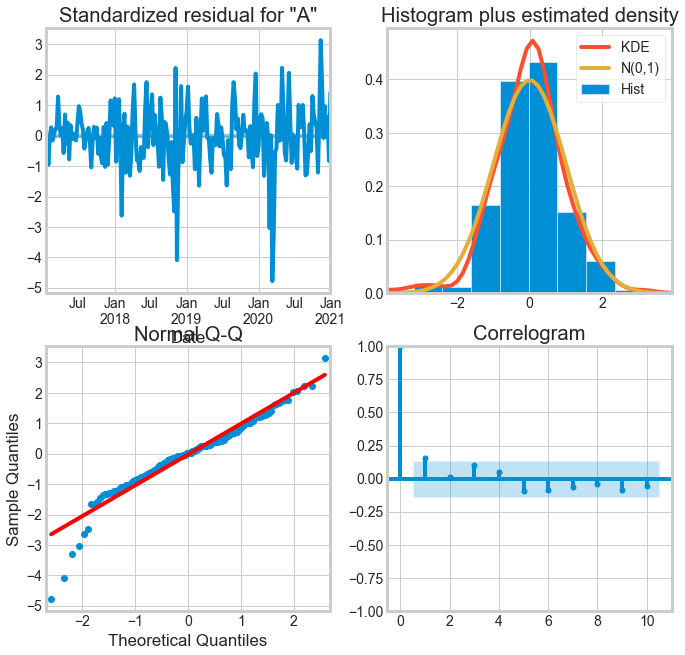

In [1598]:
model_210.plot_diagnostics();

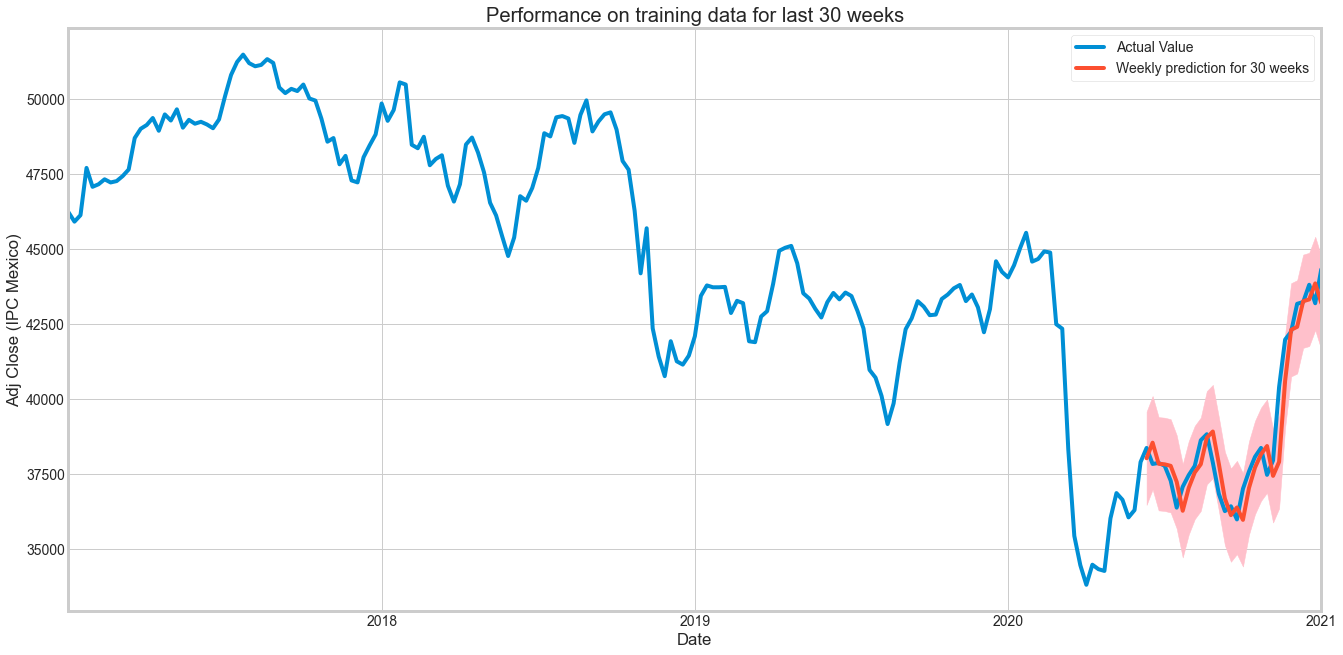

In [1599]:
#Lets see how the model performs on the training data
train["Adj Close"].plot(figsize=(20,10),label="Actual Value")
model_210.get_prediction(start=-30).predicted_mean.plot(label="Weekly prediction for 30 weeks")
conf_int_210 = model_210.get_prediction(start=-30).conf_int()
plt.fill_between(conf_int_210.index,conf_int_210["lower Adj Close"],conf_int_210["upper Adj Close"],color="pink")
plt.title("Performance on training data for last 30 weeks")
plt.ylabel("Adj Close (IPC Mexico)")
plt.legend()

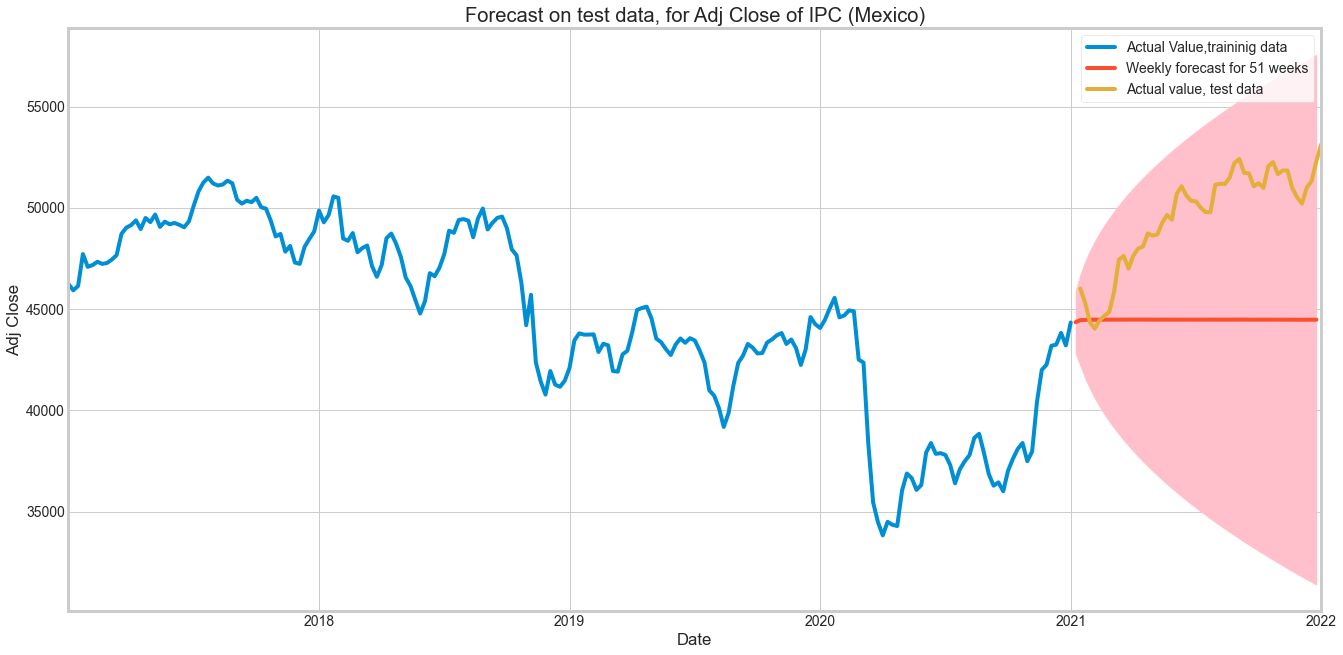

In [1600]:
#Forecasting for the next 30 weeks
train["Adj Close"].plot(figsize=(20,10),label="Actual Value,traininig data")
model_210.get_forecast(steps=51,exog =test["valence"]).predicted_mean.plot(label="Weekly forecast for 51 weeks")
test["Adj Close"].plot(label="Actual value, test data")
conf_int_forecast = model_210.get_forecast(steps=51,exog =test["valence"]).conf_int()
plt.fill_between(conf_int_forecast.index,conf_int_forecast["lower Adj Close"],conf_int_forecast["upper Adj Close"],color="pink")
plt.title("Forecast on test data, for Adj Close of IPC (Mexico)")
plt.ylabel("Adj Close")
plt.legend()

In [1601]:
from sklearn.metrics import mean_absolute_error as mae
mae(test["Adj Close"], model_210.get_forecast(steps=51,exog =test["valence"]).predicted_mean)


5111.795816621143

In [1602]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(test["Adj Close"], model_210.get_forecast(steps=51,exog =test["valence"]).predicted_mean)

10.090067464074064

## Multiple Linear Regression

### Lets make a function that will take the dataset and perform multiple linear regression, with valence, vwlence lagged by 1 week and valence lagged by 2 weeks as input

In [1181]:
def Multiple_Linear_reg(df):
    prep_data = df.resample("W").mean()[["Adj Close","valence"]]
    prep_data["valence Lagged 1"] = prep_data["valence"].shift(+1)
    prep_data["valence Lagged 2"] = prep_data["valence"].shift(+2)
    prep_data.dropna(inplace=True)
    X_train  = prep_data[["valence Lagged 1","valence","valence Lagged 2"]][0:209]
    y_train = prep_data[["Adj Close"]][0:209]
    X_test = prep_data[["valence Lagged 1","valence","valence Lagged 2"]][210:]
    y_test = prep_data[["Adj Close"]][210:]
    LR = LinearRegression()
    LR.fit(X_train,y_train)
    y_prediction =  LR.predict(X_test)
    print(f"The coefficients are {LR.coef_} and the intercept is {LR.intercept_}")
    print(f"The Mean Absolute Error is {mae(y_test,y_prediction)}")
    print(f"The Mean Absolute Percentage Error is {mean_absolute_percentage_error(y_test,y_prediction)}")
    return(prep_data)


In [1182]:
Multiple_Linear_reg(NASDAQ_data)

The coefficients are [[13534.14290068 22009.87267512 22184.82378456]] and the intercept is [-18865.92779983]
The Mean Absolute Error is 5835.262096379232
The Mean Absolute Percentage Error is 39.65086277752861


Adj Close   valence  valence Lagged 1  valence Lagged 2
Date                                                                  
2017-01-22   5051.625000  0.443790          0.436827          0.437088
2017-01-29   5123.300000  0.443049          0.443790          0.436827
2017-02-05   5134.350000  0.442857          0.443049          0.443790
2017-02-12   5192.950000  0.433586          0.442857          0.443049
2017-02-19   5294.300000  0.442455          0.433586          0.442857
...                  ...       ...               ...               ...
2021-12-05  16023.450000  0.487336          0.475834          0.451574
2021-12-12  16206.300000  0.486335          0.487336          0.475834
2021-12-19  15976.514063  0.484331          0.486335          0.487336
2021-12-26  16017.500000  0.505120          0.484331          0.486335
2022-01-02  16457.900000  0.463070          0.505120          0.484331

[259 rows x 4 columns]

In [1171]:
Multiple_Linear_reg(BVSP_data)

The coefficients are [[109865.65795303 271439.56495709  74066.15268067]] and the intercept is [-184498.73886932]
The Mean Absolute Error is 5899.218508957252
The Mean Absolute Percentage Error is 4.877087391492128


In [1172]:
Multiple_Linear_reg(IPC_data)

The coefficients are [[ -9734.38749246 -91156.09355319 -38793.25606144]] and the intercept is [129272.74962654]
The Mean Absolute Error is 7235.8755969976855
The Mean Absolute Percentage Error is 14.384065322734516


### Next we will run multiple linear regression using statsmodel to get statistical summary of the fit

In [1173]:
def Multiple_Linear_reg_stats(df):
    prep_data = df.resample("W").mean()[["Adj Close","valence"]]
    prep_data["valence Lagged 1"] = prep_data["valence"].shift(+1)
    prep_data["valence Lagged 2"] = prep_data["valence"].shift(+2)
    prep_data.dropna(inplace=True)
    X  = prep_data[["valence Lagged 1","valence","valence Lagged 2"]]
    y= prep_data[["Adj Close"]]
    X=sm.add_constant(X) 
    model = sm.OLS(y,X).fit() 
    print(model.summary())
 

In [1174]:
Multiple_Linear_reg_stats(NASDAQ_data)

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     44.00
Date:                Tue, 20 Sep 2022   Prob (F-statistic):           6.00e-23
Time:                        23:32:51   Log-Likelihood:                -2405.4
No. Observations:                 259   AIC:                             4819.
Df Residuals:                     255   BIC:                             4833.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.362e+04   3723.286  

In [1175]:
Multiple_Linear_reg_stats(BVSP_data)

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     281.0
Date:                Tue, 20 Sep 2022   Prob (F-statistic):           1.61e-80
Time:                        23:33:05   Log-Likelihood:                -2722.4
No. Observations:                 259   AIC:                             5453.
Df Residuals:                     255   BIC:                             5467.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.038e+05   1.03e+04  

In [1176]:
Multiple_Linear_reg_stats(IPC_data)

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     32.42
Date:                Tue, 20 Sep 2022   Prob (F-statistic):           8.74e-18
Time:                        23:33:38   Log-Likelihood:                -2512.2
No. Observations:                 259   AIC:                             5032.
Df Residuals:                     255   BIC:                             5047.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.088e+05   6463.032  

### LSTM :- Neural Networks Approach

In [1434]:
#importing ncessary ackages to train RNN, in order to implement LSTM time series model
from keras.models import Sequential
from keras.layers import LSTM
from keras. layers import Dense,Dropout
from sklearn.preprocessing import StandardScaler

### implementing LSTM on NASDAQ data

In [1435]:
NASDAQ_data

valence  danceability    energy    key  loudness   mode  \
Date                                                                   
2017-01-03  0.435576      0.666648  0.600927  5.228 -7.112056  0.536   
2017-01-04  0.434716      0.666992  0.605056  5.204 -6.992640  0.544   
2017-01-05  0.439952      0.670932  0.604552  5.236 -6.934576  0.540   
2017-01-06  0.438108      0.667940  0.598776  5.208 -6.957628  0.536   
2017-01-09  0.432372      0.658476  0.589656  5.084 -7.009332  0.604   
...              ...           ...       ...    ...       ...    ...   
2021-12-27  0.465930      0.657016  0.610176  4.540 -6.934032  0.636   
2021-12-28  0.459430      0.661140  0.610960  4.520 -6.884508  0.636   
2021-12-29  0.461668      0.660236  0.616168  4.560 -6.814508  0.648   
2021-12-30  0.462518      0.660128  0.615872  4.584 -6.852580  0.644   
2021-12-31  0.465804      0.669032  0.619848  4.608 -6.809192  0.652   

            speechiness  acousticness  instrumentalness  liveness       tempo  \
Date                                                                            
2017-01-03     0.135756      0.218104          0.016552  0.164992  121.103244   
2017-01-04     0.136420      0.220454          0.016665  0.167797  122.253008   
2017-01-05     0.138137      0.223657          0.018135  0.170918  122.224648   
2017-01-06     0.136861      0.237315          0.019336  0.166951  121.565448   
2017-01-09     0.142519      0.247206          0.020330  0.167113  120.864644   
...                 ...           ...               ...       ...         ...   
2021-12-27     0.121388      0.251793          0.037644  0.181452  123.319512   
2021-12-28     0.120431      0.245971          0.037644  0.178365  122.883804   
2021-12-29     0.118047      0.244089          0.037628  0.179467  122.422696   
2021-12-30     0.116932      0.242179          0.037629  0.182258  122.669864   
2021-12-31     0.124722      0.231239          0.034249  0.181224  122.285440   

                High       Low      Open     Close  Volume  Adj Close  
Date                                                                   
2017-01-03   4927.50   4876.75   4876.75   4906.25  215983    4906.25  
2017-01-04   4942.50   4903.00   4906.50   4933.50  171952    4933.50  
2017-01-05   4964.25   4920.50   4934.75   4962.00  169565    4962.00  
2017-01-06   5017.50   4952.50   4962.50   5004.00  183315    5004.00  
2017-01-09   5029.50   5002.50   5004.50   5022.00  148112    5022.00  
...              ...       ...       ...       ...     ...        ...  
2021-12-27  16580.75  16304.25  16304.25  16560.00  351308   16560.00  
2021-12-28  16659.50  16452.25  16565.75  16488.00  454633   16488.00  
2021-12-29  16564.25  16387.50  16513.50  16490.50  354985   16490.50  
2021-12-30  16567.50  16411.25  16484.50  16430.25  304259   16430.25  
2021-12-31  16464.00  16313.75  16431.00  16320.75  363720   16320.75  

[1260 rows x 17 columns]

In [1436]:
# We  will be training a multivariate time series model, and for this purpose we take mean,High,Low,Open,Close and Adj Close
LSTM_NASDAQ = NASDAQ_data[["valence","High","Low","Open","Close","Adj Close"]]

In [1437]:
LSTM_NASDAQ.dtypes

valence      float64
High         float64
Low          float64
Open         float64
Close        float64
Adj Close    float64
dtype: object

In [1438]:
LSTM_NASDAQ.shape

(1260, 6)

In [1439]:
train = LSTM_NASDAQ.iloc[0:1008]
test = LSTM_NASDAQ.iloc[1008:]

In [1440]:
train1 = LSTM_NASDAQ.iloc[0:1008]
test1 = LSTM_NASDAQ.iloc[1008:]

In [1441]:
##Lets get the date for index
date = train.index

In [1442]:
#Dropping the date column before training the model
train = train.reset_index().drop(columns={"Date"})

In [1443]:
#We need to scale the data to the same range
scaler = StandardScaler()
scaler = scaler.fit(train[["valence","High","Low","Open","Close","Adj Close"]])
train_scaled = scaler.transform(train)

In [1444]:
train.shape

(1008, 6)

In [1445]:
#scaler.inverse_transform(np.repeat(trainY, train.shape[1], axis=-1))[:,5]

In [1446]:
#train_scaled

In [1447]:
train_scaled.shape

(1008, 6)

In [1448]:
# for this case we need to create a window size which will be represented as an arrary, with each window consisting of 15 elements and each elements having 6 attributes values. This will be mapped to the output, i.e Adjusted Close for the next trading day
trainX = []
trainY = []

In [1449]:
n_future = 1
n_past = 3

In [1450]:
for i in range(n_past, len(train_scaled) - n_future +1):
    trainX.append(train_scaled[i - n_past:i, 0:train_scaled.shape[1]-1])
    trainY.append(train_scaled[i + n_future - 1:i + n_future, 5])

In [1451]:
trainX,trainY = np.array(trainX),np.array(trainY)

In [1452]:
trainX.shape

(1005, 3, 5)

In [1453]:
trainY.shape

(1005, 1)

In [1454]:

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 3, 64)             17920     
                                                                 
 lstm_59 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_29 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [1455]:
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/30
57/57 [==============================] - 32s 97ms/step - loss: 0.2660 - val_loss: 0.8927
Epoch 2/30
57/57 [==============================] - 2s 29ms/step - loss: 0.0340 - val_loss: 0.1653
Epoch 3/30
57/57 [==============================] - 1s 25ms/step - loss: 0.0224 - val_loss: 0.0839
Epoch 4/30
57/57 [==============================] - 2s 44ms/step - loss: 0.0210 - val_loss: 0.0410
Epoch 5/30
57/57 [==============================] - 2s 26ms/step - loss: 0.0199 - val_loss: 0.0432
Epoch 6/30
57/57 [==============================] - 1s 23ms/step - loss: 0.0189 - val_loss: 0.0663
Epoch 7/30
57/57 [==============================] - 2s 32ms/step - loss: 0.0158 - val_loss: 0.0239
Epoch 8/30
57/57 [==============================] - 2s 34ms/step - loss: 0.0220 - val_loss: 0.1550
Epoch 9/30
57/57 [==============================] - 1s 22ms/step - loss: 0.0176 - val_loss: 0.0375
Epoch 10/30
57/57 [==============================] - 1s 23ms/step - loss: 0.0166 - val_loss: 0.0242
Epoch 11

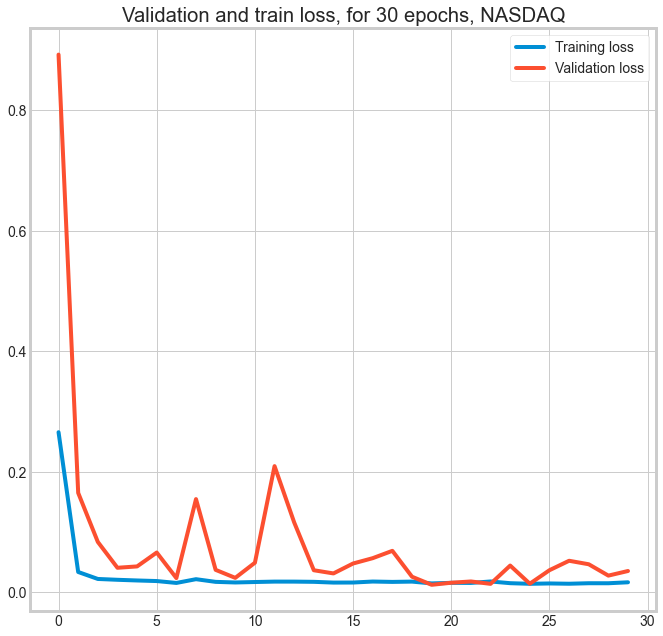

In [1456]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Validation and train loss, for 30 epochs, NASDAQ")
plt.legend()

In [1457]:

#Make prediction
prediction = model.predict(trainX[-90:]) #shape = (n, 1) where n is the n_days_for_prediction


In [1458]:
us_bd

<CustomBusinessDay>

In [1459]:
prediction_copies = np.repeat(prediction, train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]


In [1460]:
y_pred_future.shape

(90,)

In [1461]:
y_pred_future

array([11476.125, 11641.226, 11707.793, 11755.607, 11808.237, 11942.215,
       12092.715, 11709.218, 11249.258, 11065.235, 11039.393, 11016.496,
       10889.349, 11029.795, 11142.628, 11127.593, 10948.412, 10942.749,
       10725.914, 10851.414, 10728.892, 10673.924, 10820.006, 10992.792,
       11091.569, 11133.322, 11239.474, 11119.471, 11168.058, 11091.65 ,
       11142.317, 11270.722, 11394.979, 11631.407, 11806.602, 11739.428,
       11641.401, 11632.09 , 11479.869, 11444.691, 11436.329, 11384.936,
       11358.817, 11305.681, 11341.403, 11062.982, 11088.717, 10910.272,
       10859.712, 10954.43 , 11235.669, 11564.808, 11716.428, 11692.529,
       11427.517, 11527.805, 11583.522, 11621.5  , 11648.673, 11699.558,
       11651.358, 11661.087, 11617.238, 11634.511, 11747.514, 11818.201,
       11888.59 , 11973.295, 12120.901, 12078.516, 12143.891, 12165.606,
       12183.321, 12259.606, 12125.194, 12066.507, 12107.421, 12187.78 ,
       12202.815, 12293.593, 12355.99 , 12393.994, 

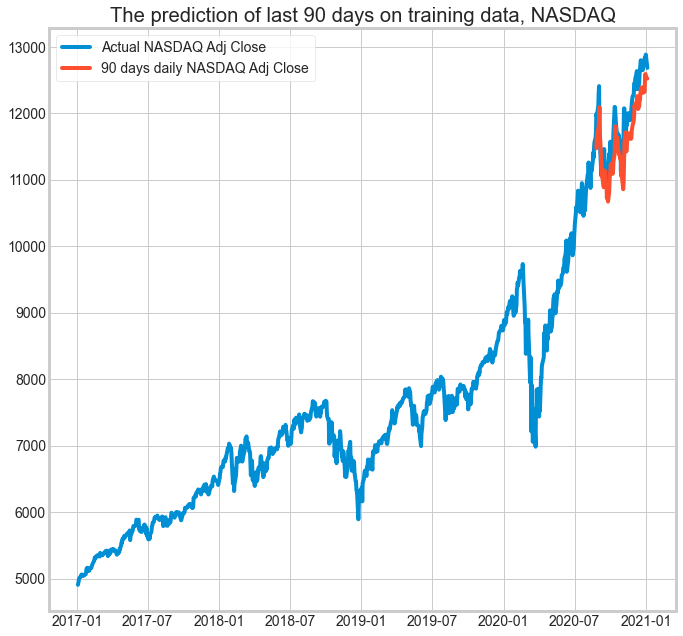

In [1462]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Adj Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

original = train1.reset_index()[['Date', 'Adj Close']]
original['Date']=pd.to_datetime(original['Date'])


plt.title("The prediction of last 90 days on training data, NASDAQ")
plt.plot(original['Date'], original['Adj Close'],label="Actual NASDAQ Adj Close")
plt.plot(original['Date'][-90:], df_forecast['Adj Close'],label="90 days daily NASDAQ Adj Close")
plt.legend()



In [1463]:
df_forecast['Adj Close']

0     11476.125000
1     11641.225586
2     11707.792969
3     11755.607422
4     11808.237305
          ...     
85    12327.473633
86    12557.764648
87    12593.216797
88    12545.906250
89    12525.838867
Name: Adj Close, Length: 90, dtype: float32

### Above shows the performance on the training dataset

### Moving on, Lets see the performance on the test dataset

In [1464]:
#testX = []
#We need to scale the data to the same range
scaler = StandardScaler()
scaler = scaler.fit(test[["valence","High","Low","Open","Close","Adj Close"]])
test_scaled = scaler.transform(test)

In [1465]:
n_future = 1
n_past = 3

In [1466]:
test_scaled.shape

(252, 6)

In [1467]:
testX = []
testY = []

In [1468]:
for i in range(n_past, len(test_scaled) - n_future +1):
    testX.append(test_scaled[i - n_past:i, 0:test_scaled.shape[1]-1])
    testY.append(test_scaled[i + n_future - 1:i + n_future, 5])

In [1469]:
testX,testY = np.array(testX),np.array(testY)

In [1470]:
prediction_unknown = model.predict(testX)

In [1471]:
prediction_unknown.shape

(249, 1)

In [1472]:
prediction_copies = np.repeat(prediction_unknown, train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]

In [1473]:
y_pred_future.shape

(249,)

In [1474]:
test1[3:]

valence      High       Low      Open     Close  Adj Close
Date                                                                   
2021-01-08  0.499441  13125.00  12919.00  12927.00  13097.25   13097.25
2021-01-11  0.495777  13105.25  12871.75  13093.25  12897.00   12897.00
2021-01-12  0.491357  12959.00  12767.25  12910.75  12890.25   12890.25
2021-01-13  0.490085  13003.00  12820.75  12882.50  12972.25   12972.25
2021-01-14  0.484025  13028.75  12881.00  12975.50  12901.00   12901.00
...              ...       ...       ...       ...       ...        ...
2021-12-27  0.465930  16580.75  16304.25  16304.25  16560.00   16560.00
2021-12-28  0.459430  16659.50  16452.25  16565.75  16488.00   16488.00
2021-12-29  0.461668  16564.25  16387.50  16513.50  16490.50   16490.50
2021-12-30  0.462518  16567.50  16411.25  16484.50  16430.25   16430.25
2021-12-31  0.465804  16464.00  16313.75  16431.00  16320.75   16320.75

[249 rows x 6 columns]

In [1475]:
#preparing the data-frame for plotting
y_pred_future
pred = pd.DataFrame({"Adj Close Predicted":y_pred_future,"Date":test1.index[3:]})
pred["Date"] = pred["Date"].astype("datetime64[ns]")
pred = pred.set_index("Date")

<AxesSubplot:title={'center':'The prediction of 245 days on test data, NASDAQ'}, xlabel='Date', ylabel='Adj Close'>

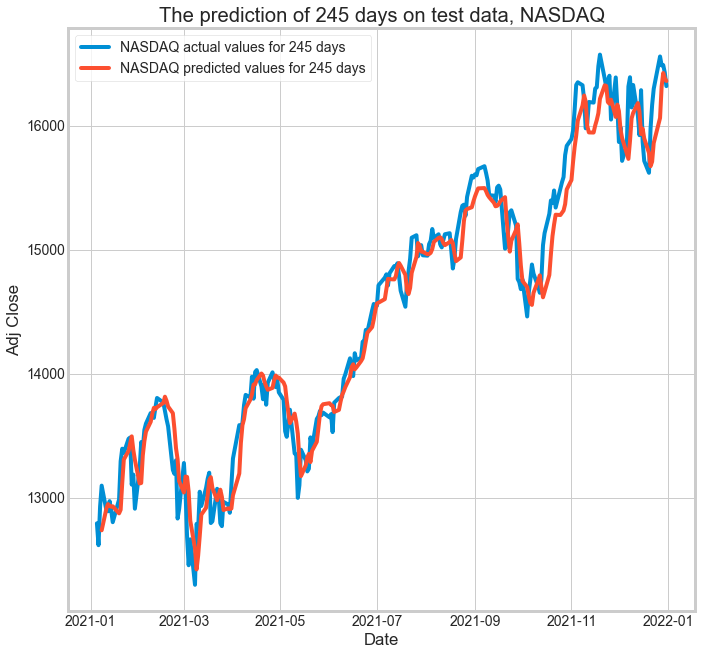

In [1476]:
plt.title("The prediction of 245 days on test data, NASDAQ")
sns.lineplot(test1.index, test1["Adj Close"],label="NASDAQ actual values for 245 days")
sns.lineplot(pred.index, pred["Adj Close Predicted"],label="NASDAQ predicted values for 245 days")

In [1477]:
from sklearn.metrics import mean_absolute_error as mae
mae(test1["Adj Close"][3:], pred["Adj Close Predicted"])

167.7850268260542

In [1478]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(test1["Adj Close"][3:], pred["Adj Close Predicted"])

1.1576881165455737

### Lets automate the code and call it for the remaining two stock market

In [1479]:
def LSTM_implementation(df,Stock_market):
    '''The function gets stock-market and spotify features data-frame, as well as the name of stock market as string, and returns
        the output obtained from LSTM, trined on 30 epochs
    '''
    #getting only few columns from the data-frame, which will be used to train the model
    LSTM_df = df[["valence","High","Low","Open","Close","Adj Close"]]
    # we have taken first 1008 rows, as we want to do 80%-20% train-test split
    train = LSTM_df.iloc[0:1008]
    test = LSTM_df.iloc[1008:]
    #we will store the same data in another variables, which will be used at the time of plotting
    train1 = LSTM_df.iloc[0:1008]
    test1 = LSTM_df.iloc[1008:]
    #Lets get the date for index
    date = train.index
    #Dropping the date column before training the model, as the input to the neural networks should onlt be martix
    train = train.reset_index().drop(columns={"Date"})
    #We need to scale the data to the same range
    scaler = StandardScaler()
    scaler = scaler.fit(train[["valence","High","Low","Open","Close","Adj Close"]])
    train_scaled = scaler.transform(train)
    # for this case we need to create a window size which will be represented as an arrary, with each window consisting of 3 elements and each elements having 5 attributes values. This will be mapped to the output, i.e Adjusted Close for the next trading day
    trainX = []
    trainY = []
    n_future = 1
    n_past = 3
    #Next we create a for loop which will give help us get the input in the desired format
    for i in range(n_past, len(train_scaled) - n_future +1):
        trainX.append(train_scaled[i - n_past:i, 0:train_scaled.shape[1]-1])
        trainY.append(train_scaled[i + n_future - 1:i + n_future, 5])
    trainX,trainY = np.array(trainX),np.array(trainY)
    
    #adding layers, for neural networks implementation, and compiling the model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    #fitting the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)
    #plotting the data to see how it does, in terms of loss reduction at each epochs traversal
    plt.plot(history.history['loss'], label='Training loss',)
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(f"Validation and train loss, for 30 epochs, {Stock_market}")
    plt.legend()
    plt.show()
     


    #Make prediction
    prediction = model.predict(trainX[-90:]) 
    prediction_copies = np.repeat(prediction, train.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]
    # Convert timestamp to date
    forecast_dates = []
    for time_i in predict_period_dates:
        forecast_dates.append(time_i.date())

    df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Adj Close':y_pred_future})
    df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

    original = train1.reset_index()[['Date', 'Adj Close']]
    original['Date']=pd.to_datetime(original['Date'])


    plt.title(f"The prediction of last 90 days on training data, {Stock_market}")
    plt.plot(original['Date'], original['Adj Close'],label=f"Actual {Stock_market} Adj Close")
    plt.plot(original['Date'][-90:], df_forecast['Adj Close'],label=f"90 days daily {Stock_market} Adj Close")
    plt.legend()
    plt.show()

    

    #lets get the train data ready to make forecast and see how our model is doing 
    scaler = StandardScaler()
    scaler = scaler.fit(test[["valence","High","Low","Open","Close","Adj Close"]])
    test_scaled = scaler.transform(test)
    n_future = 1
    n_past = 3
    testX = []
    testY = []
    for i in range(n_past, len(test_scaled) - n_future +1):
        testX.append(test_scaled[i - n_past:i, 0:test_scaled.shape[1]-1])
        testY.append(test_scaled[i + n_future - 1:i + n_future, 5])
    testX,testY = np.array(testX),np.array(testY)
    prediction_unknown = model.predict(testX)
    prediction_copies = np.repeat(prediction_unknown, train.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]
    #preparing the data-frame for plotting
    pred = pd.DataFrame({"Adj Close Predicted":y_pred_future,"Date":test1.index[3:]})
    pred["Date"] = pred["Date"].astype("datetime64[ns]")
    pred = pred.set_index("Date")
    plt.title(f"the prediction of {y_pred_future.shape[0]} days on test data, {Stock_market}")
    sns.lineplot(test1.index, test1["Adj Close"],label=f"{Stock_market} actual values for {y_pred_future.shape[0]} days")
    sns.lineplot(pred.index, pred["Adj Close Predicted"],label=f"{Stock_market} predicted values for {y_pred_future.shape[0]} days")
    plt.show()
    print(mae(test1["Adj Close"][3:], pred["Adj Close Predicted"]))
    print(mean_absolute_percentage_error(test1["Adj Close"][3:], pred["Adj Close Predicted"]))
    

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 3, 64)             17920     
                                                                 
 lstm_61 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
57/57 [==============================] - 11s 36ms/step - loss: 0.3830 - val_loss: 0.0669
Epoch 2/30
57/57 [==============================] - 1s 24ms/step - loss: 0.0524 -

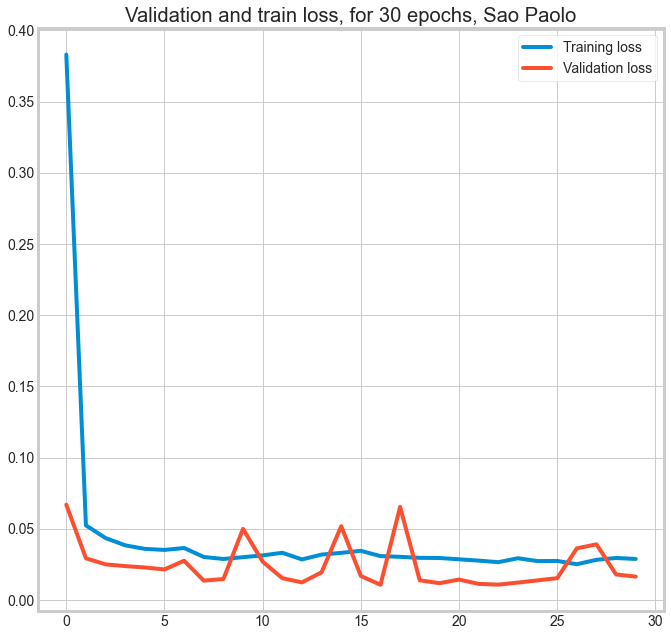

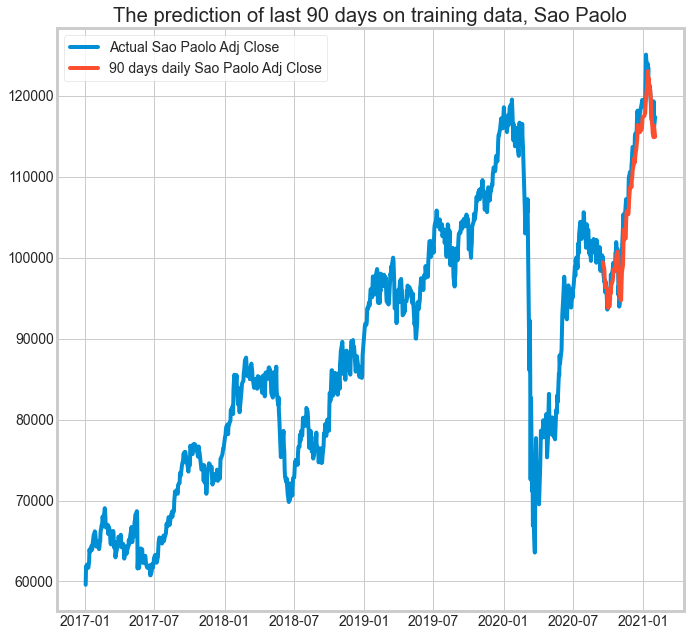

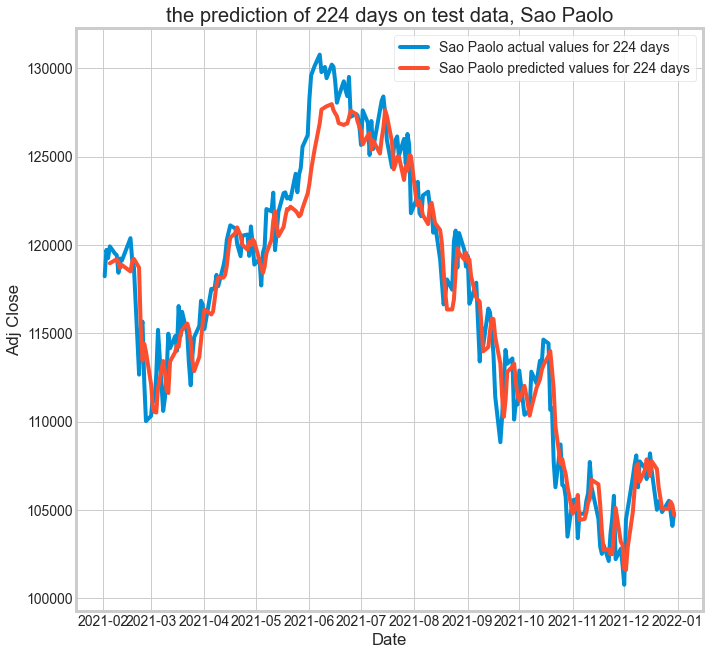

1408.941127232143
1.2098660513969093


In [1480]:
LSTM_implementation(BVSP_data,"Sao Paolo")

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 3, 64)             17920     
                                                                 
 lstm_63 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
57/57 [==============================] - 8s 59ms/step - loss: 0.4516 - val_loss: 0.0720
Epoch 2/30
57/57 [==============================] - 1s 22ms/step - loss: 0.0652 - 

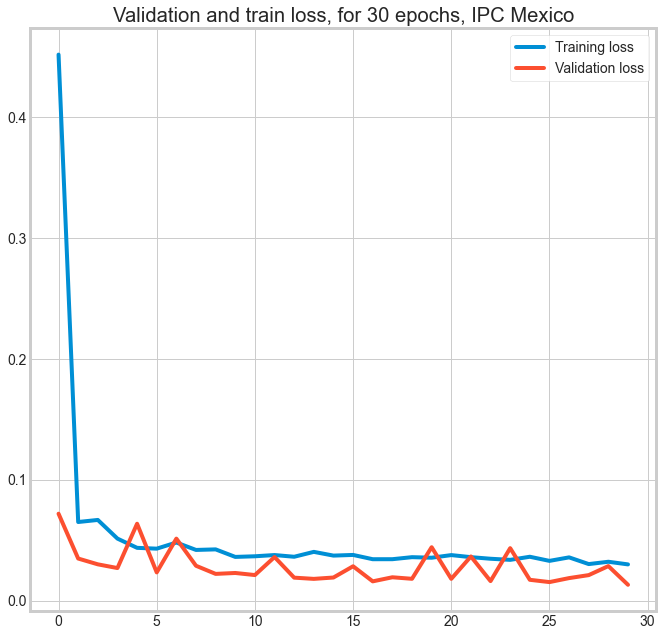

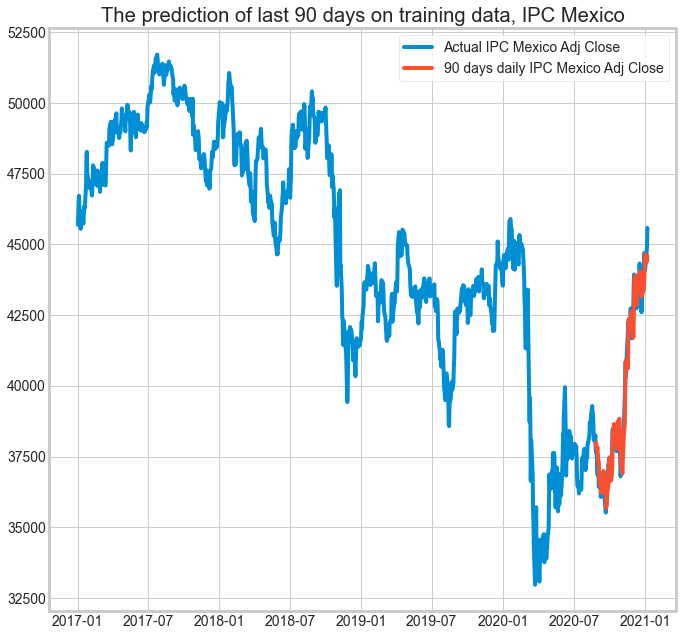

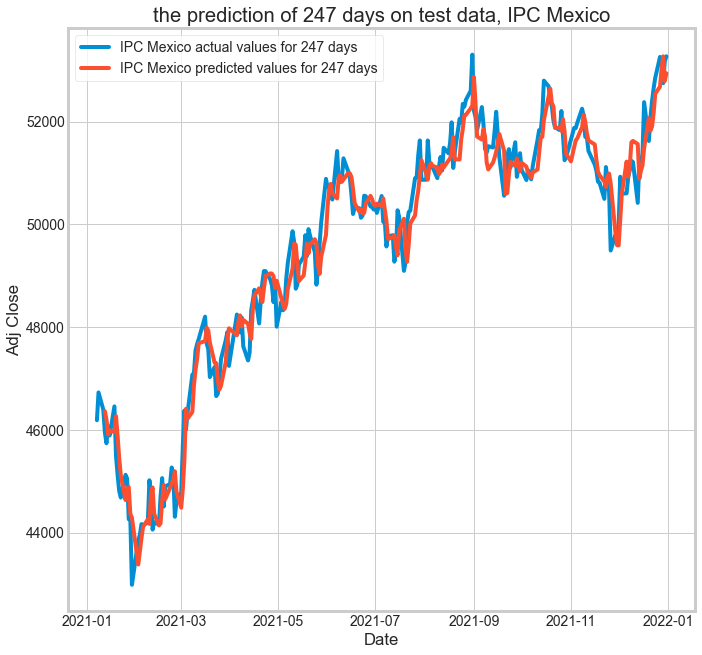

357.45201796558706
0.7253139297793721


In [1481]:
LSTM_implementation(IPC_data,"IPC Mexico")

In [1482]:
NASDAQ_data.shape

(1260, 17)

In [1603]:
metrics = {"Methods":["LSTM with valence","LSTM with valence","LSTM with valence","ARIMA","ARIMA","ARIMA","MLE","MLE","MLE"],"Stock Market":["NASDAQ","Sao Paolo","IPC Mexico","NASDAQ","Sao Paolo","IPC Mexico","NASDAQ","Sao Paolo","IPC Mexico"],"MAPE":[1.15,1.2,0.72,10.52,11.38,10.09,39.6,4.8,14.4]}

In [1604]:
RO = pd.DataFrame(metrics)

In [1605]:
RO

Methods Stock Market   MAPE
0  LSTM with valence       NASDAQ   1.15
1  LSTM with valence    Sao Paolo   1.20
2  LSTM with valence   IPC Mexico   0.72
3              ARIMA       NASDAQ  10.52
4              ARIMA    Sao Paolo  11.38
5              ARIMA   IPC Mexico  10.09
6                MLE       NASDAQ  39.60
7                MLE    Sao Paolo   4.80
8                MLE   IPC Mexico  14.40

<AxesSubplot:xlabel='Methods', ylabel='MAPE'>

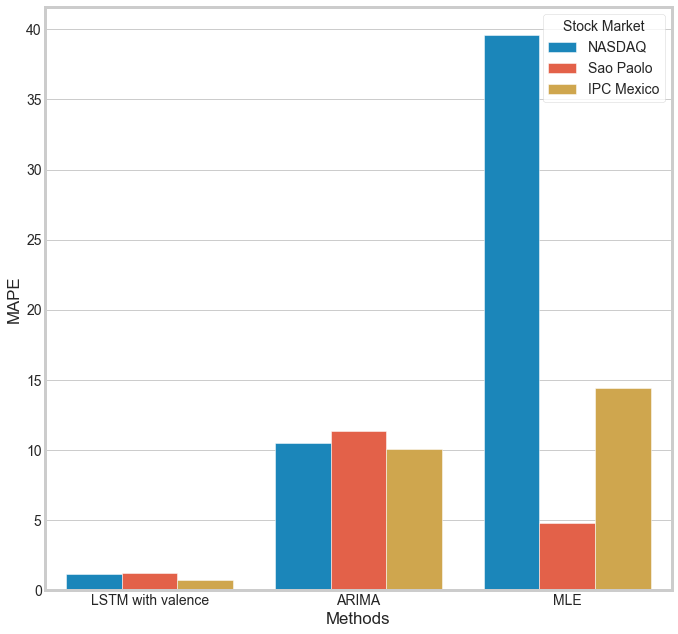

In [1606]:
sns.barplot(data=RO, x="Methods", y="MAPE", hue='Stock Market')

#### Next lets re-run the code, but in this case we donot take valence in the model

In [1497]:
def LSTM_implementation_without_spotify(df,Stock_market):
    '''The function gets the data desnote take into account valence for training, and returns
        the output obtained from LSTM, trined on 30 epochs
    '''
    #getting only few columns from the data-frame, which will be used to train the model
    LSTM_df = df[["High","Low","Open","Close","Adj Close"]]
    # we have taken first 1008 rows, as we want to do 80%-20% train-test split
    train = LSTM_df.iloc[0:1008]
    test = LSTM_df.iloc[1008:]
    #we will store the same data in another variables, which will be used at the time of plotting
    train1 = LSTM_df.iloc[0:1008]
    test1 = LSTM_df.iloc[1008:]
    #Lets get the date for index
    date = train.index
    #Dropping the date column before training the model, as the input to the neural networks should onlt be martix
    train = train.reset_index().drop(columns={"Date"})
    #We need to scale the data to the same range
    scaler = StandardScaler()
    scaler = scaler.fit(train[["High","Low","Open","Close","Adj Close"]])
    train_scaled = scaler.transform(train)
    # for this case we need to create a window size which will be represented as an arrary, with each window consisting of 3 elements and each elements having 5 attributes values. This will be mapped to the output, i.e Adjusted Close for the next trading day
    trainX = []
    trainY = []
    n_future = 1
    n_past = 3
    #Next we create a for loop which will give help us get the input in the desired format
    for i in range(n_past, len(train_scaled) - n_future +1):
        trainX.append(train_scaled[i - n_past:i, 0:train_scaled.shape[1]-1])
        trainY.append(train_scaled[i + n_future - 1:i + n_future, 4])
    trainX,trainY = np.array(trainX),np.array(trainY)
    
    #adding layers, for neural networks implementation, and compiling the model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    #fitting the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)
    #plotting the data to see how it does, in terms of loss reduction at each epochs traversal
    plt.plot(history.history['loss'], label='Training loss',)
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(f"Validation and train loss, for 30 epochs, {Stock_market}")
    plt.legend()
    plt.show()
     


    #Make prediction
    prediction = model.predict(trainX[-90:]) 
    prediction_copies = np.repeat(prediction, train.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,4]
    # Convert timestamp to date
    forecast_dates = []
    for time_i in predict_period_dates:
        forecast_dates.append(time_i.date())

    df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Adj Close':y_pred_future})
    df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

    original = train1.reset_index()[['Date', 'Adj Close']]
    original['Date']=pd.to_datetime(original['Date'])


    plt.title(f"The prediction of last 90 days on training data, {Stock_market}")
    plt.plot(original['Date'], original['Adj Close'],label=f"Actual {Stock_market} Adj Close")
    plt.plot(original['Date'][-90:], df_forecast['Adj Close'],label=f"90 days daily {Stock_market} Adj Close")
    plt.legend()
    plt.show()

    

    #lets get the train data ready to make forecast and see how our model is doing 
    scaler = StandardScaler()
    scaler = scaler.fit(test[["High","Low","Open","Close","Adj Close"]])
    test_scaled = scaler.transform(test)
    n_future = 1
    n_past = 3
    testX = []
    testY = []
    for i in range(n_past, len(test_scaled) - n_future +1):
        testX.append(test_scaled[i - n_past:i, 0:test_scaled.shape[1]-1])
        testY.append(test_scaled[i + n_future - 1:i + n_future, 4])
    testX,testY = np.array(testX),np.array(testY)
    prediction_unknown = model.predict(testX)
    prediction_copies = np.repeat(prediction_unknown, train.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,4]
    #preparing the data-frame for plotting
    pred = pd.DataFrame({"Adj Close Predicted":y_pred_future,"Date":test1.index[3:]})
    pred["Date"] = pred["Date"].astype("datetime64[ns]")
    pred = pred.set_index("Date")
    plt.title(f"the prediction of {y_pred_future.shape[0]} days on test data, {Stock_market}")
    sns.lineplot(test1.index, test1["Adj Close"],label=f"{Stock_market} actual values for {y_pred_future.shape[0]} days")
    sns.lineplot(pred.index, pred["Adj Close Predicted"],label=f"{Stock_market} predicted values for {y_pred_future.shape[0]} days")
    plt.show()
    print(mae(test1["Adj Close"][3:], pred["Adj Close Predicted"]))
    print(mean_absolute_percentage_error(test1["Adj Close"][3:], pred["Adj Close Predicted"]))
    

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 3, 64)             17664     
                                                                 
 lstm_71 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
57/57 [==============================] - 6s 38ms/step - loss: 0.2466 - val_loss: 4.8062
Epoch 2/30
57/57 [==============================] - 2s 27ms/step - loss: 0.0471 - 

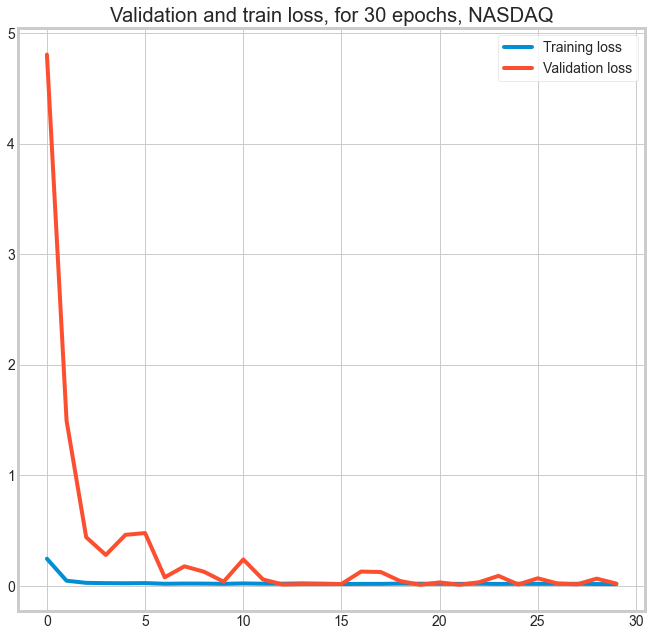

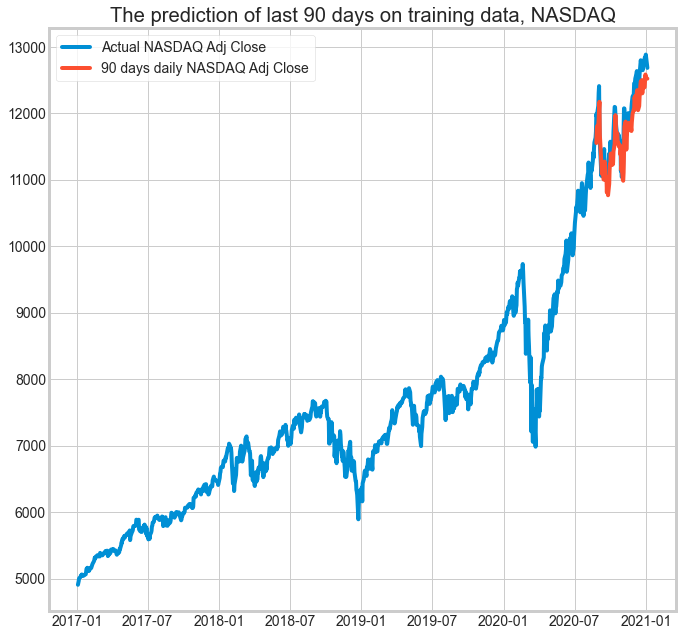

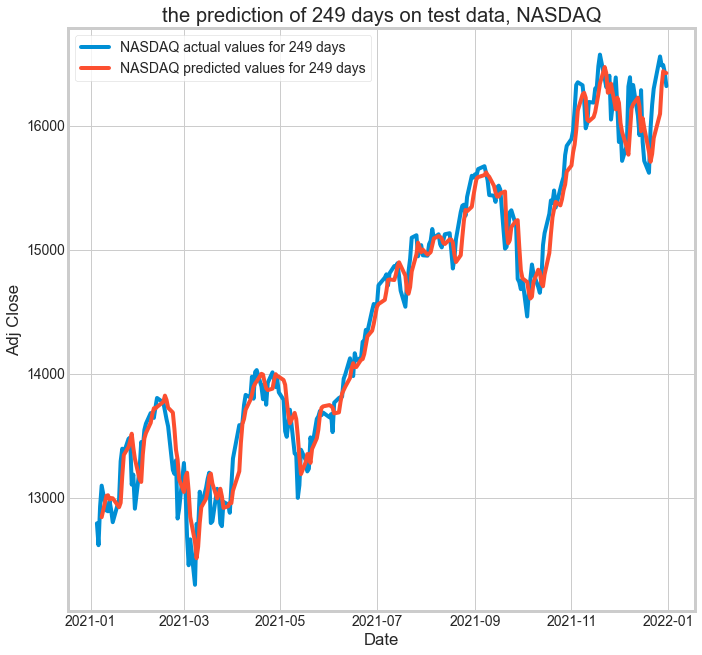

151.57996438880522
1.0531398111352845


In [1498]:
LSTM_implementation_without_spotify(NASDAQ_data,"NASDAQ")

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 3, 64)             17664     
                                                                 
 lstm_73 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_36 (Dropout)        (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
57/57 [==============================] - 6s 32ms/step - loss: 0.4305 - val_loss: 0.0685
Epoch 2/30
57/57 [==============================] - 1s 22ms/step - loss: 0.0481 - 

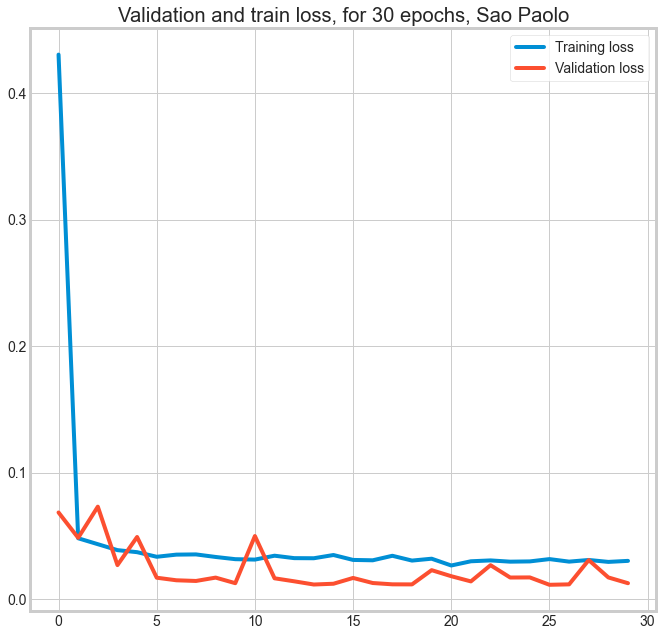

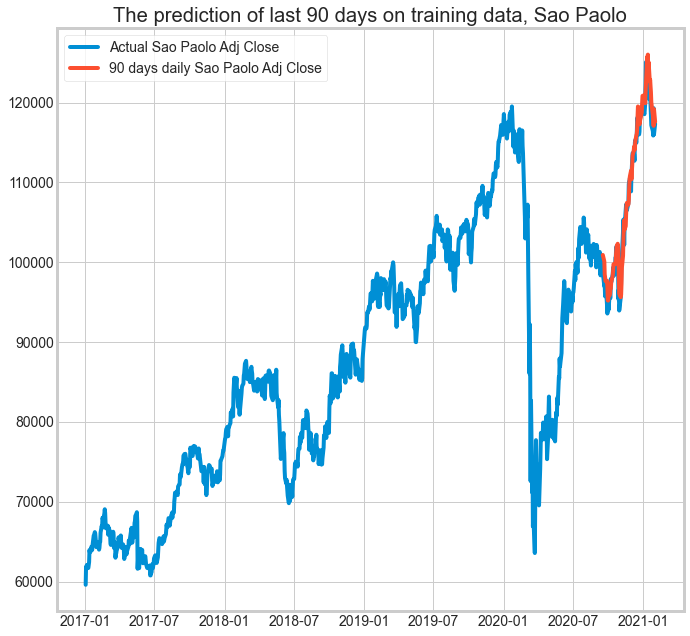

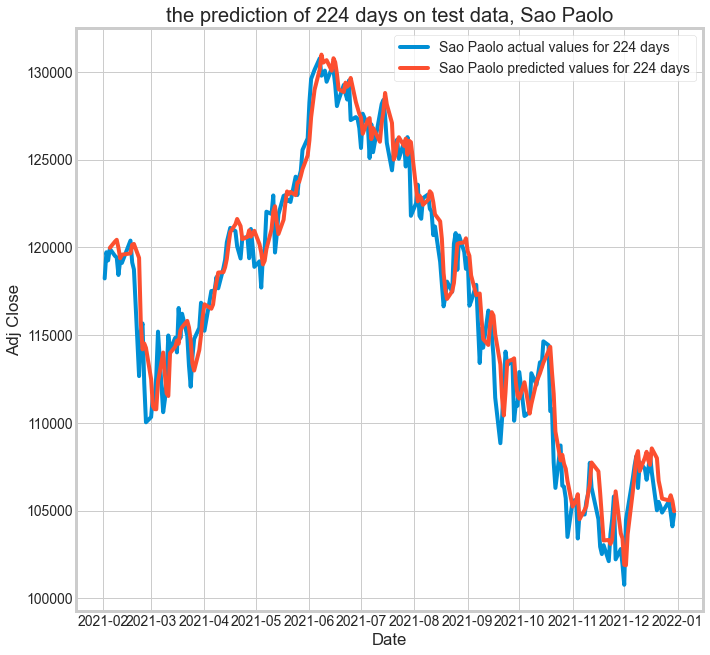

1250.7752511160713
1.089898835327787


In [1499]:
LSTM_implementation_without_spotify(BVSP_data,"Sao Paolo")

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 3, 64)             17664     
                                                                 
 lstm_75 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_37 (Dropout)        (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
57/57 [==============================] - 5s 28ms/step - loss: 0.3862 - val_loss: 0.0738
Epoch 2/30
57/57 [==============================] - 1s 21ms/step - loss: 0.0630 - 

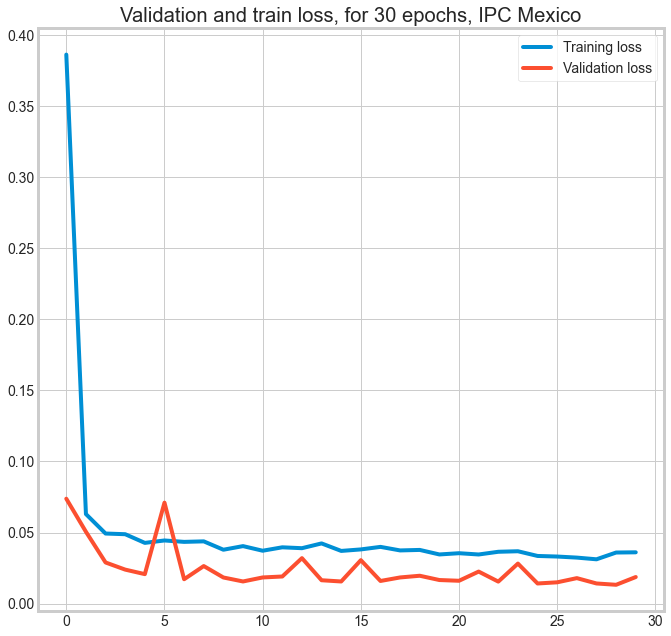

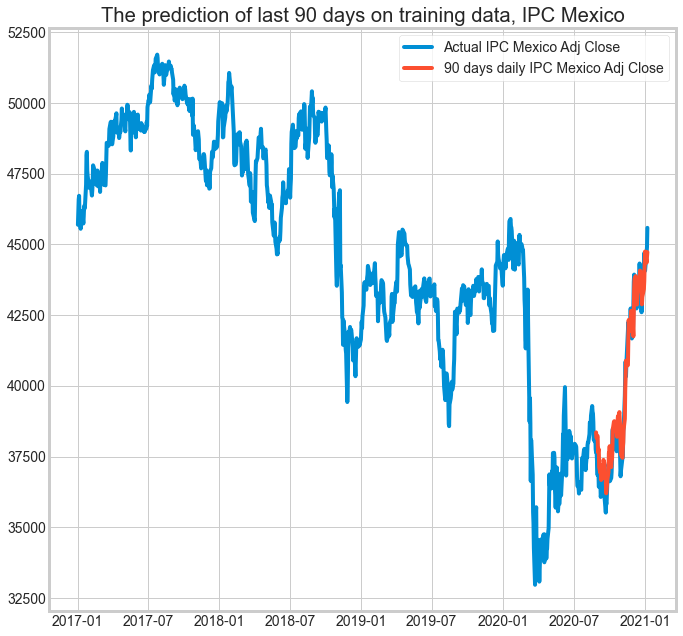

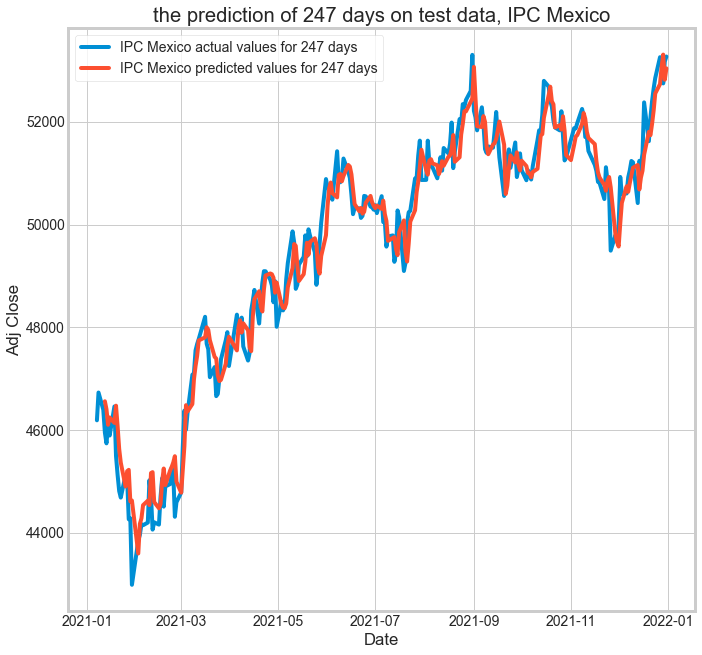

352.21539726720647
0.7173972228943835


In [1500]:
LSTM_implementation_without_spotify(IPC_data,"IPC Mexico")

In [1512]:
metrics = {"Run Condition":["With Valence","With Valence","With Valence","Without Valence","Without Valence","Without Valence"],"Stock Market":["NASDAQ","Sao Paolo","IPC Mexico","NASDAQ","Sao Paolo","IPC Mexico"],"MAE":[167,1408,357,151,1250,352],"MAPE":[1.15,1.2,0.72,1.05,1.08,0.71]}

In [1513]:
RO = pd.DataFrame(metrics)

In [1514]:
RO

Run Condition Stock Market   MAE  MAPE
0     With Valence       NASDAQ   167  1.15
1     With Valence    Sao Paolo  1408  1.20
2     With Valence   IPC Mexico   357  0.72
3  Without Valence       NASDAQ   151  1.05
4  Without Valence    Sao Paolo  1250  1.08
5  Without Valence   IPC Mexico   352  0.71

<AxesSubplot:xlabel='MAPE', ylabel='Stock Market'>

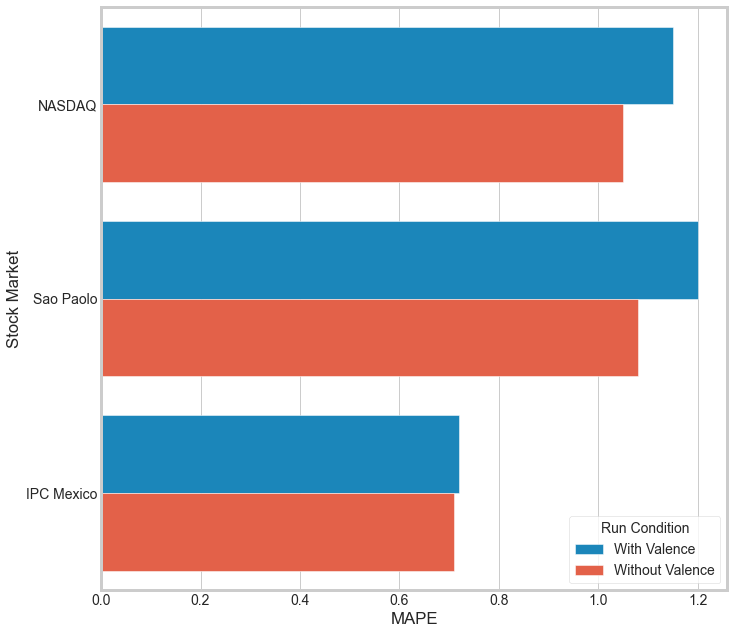

In [1515]:
sns.barplot(data=RO, y="Stock Market", x="MAPE", hue='Run Condition')

<AxesSubplot:xlabel='MAE', ylabel='Stock Market'>

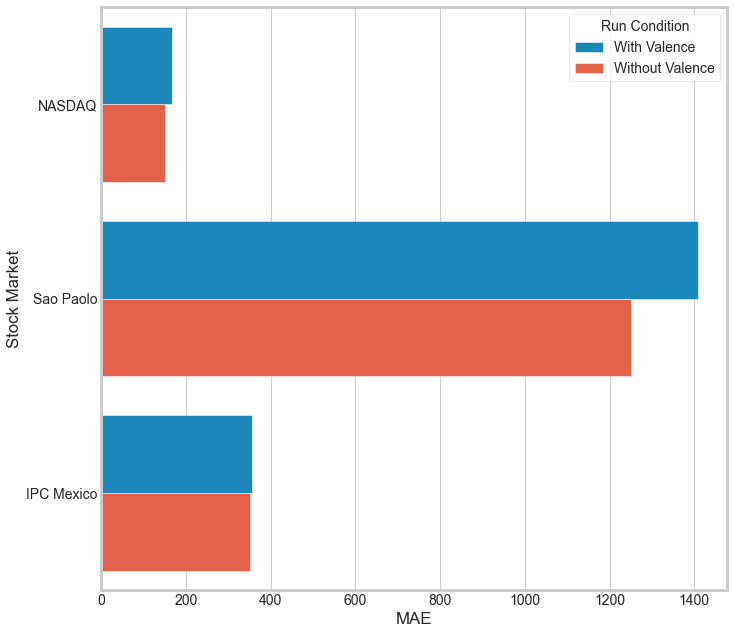

In [1516]:
sns.barplot(data=RO, y="Stock Market", x="MAE", hue='Run Condition')